In [1]:
import os.path as osp
import torch
import torch.nn.functional as F
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import (v_measure_score, homogeneity_score, completeness_score)
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.nn.models.autoencoder import ARGVA
from torch_geometric.utils import train_test_split_edges

In [2]:
dataset = 'Cora'
path = osp.join('.', 'data', dataset)
dataset = Planetoid(path, dataset, transform=T.NormalizeFeatures())
data = dataset.get(0)

In [3]:
num_nodes = data.x.shape[0]

In [4]:
data.train_mask = data.val_mask = data.test_mask = None
data = train_test_split_edges(data)
data

Data(test_neg_edge_index=[2, 527], test_pos_edge_index=[2, 527], train_neg_adj_mask=[2708, 2708], train_pos_edge_index=[2, 8976], val_neg_edge_index=[2, 263], val_pos_edge_index=[2, 263], x=[2708, 1433], y=[2708])

## Define the model

In [5]:
class VEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(VEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels, cached=True)
        self.conv_mu = GCNConv(2 * out_channels, out_channels, cached=True)
        self.conv_logstd = GCNConv(2 * out_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        return self.conv_mu(x, edge_index), self.conv_logstd(x, edge_index)

In [6]:
class Discriminator(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(Discriminator, self).__init__()
        self.lin1 = torch.nn.Linear(in_channels, hidden_channels)
        self.lin2 = torch.nn.Linear(hidden_channels, hidden_channels)
        self.lin3 = torch.nn.Linear(hidden_channels, out_channels)

    def forward(self, x):
        x = F.relu(self.lin1(x))
        x = F.relu(self.lin2(x))
        x = self.lin3(x)
        return x

In [7]:
def train():
    model.train()
    encoder_optimizer.zero_grad()
    
    z = model.encode(data.x, data.train_pos_edge_index)

    for _ in range(5):
        idx = range(num_nodes)  
        discriminator.train()
        discriminator_optimizer.zero_grad()
        discriminator_loss = model.discriminator_loss(z[idx]) # Comment
        discriminator_loss.backward(retain_graph=True)
        discriminator_optimizer.step()
 
    loss = 0
    loss = loss + model.reg_loss(z)  # Comment
    
    loss = loss + model.recon_loss(z, data.train_pos_edge_index)
    loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()

    encoder_optimizer.step()
    
    return loss

In [8]:
@torch.no_grad()
def test():
    model.eval()
    z = model.encode(data.x, data.train_pos_edge_index)

    # Cluster embedded values using k-means.
    kmeans_input = z.cpu().numpy()
    kmeans = KMeans(n_clusters=7, random_state=0).fit(kmeans_input)
    pred = kmeans.predict(kmeans_input)

    labels = data.y.cpu().numpy()
    completeness = completeness_score(labels, pred)
    hm = homogeneity_score(labels, pred)
    nmi = v_measure_score(labels, pred)

    auc, ap = model.test(z, data.test_pos_edge_index, data.test_neg_edge_index)

    return auc, ap, completeness, hm, nmi

In [9]:
latent_size = 32
encoder = VEncoder(data.num_features, out_channels=latent_size)

discriminator = Discriminator(in_channels=latent_size, hidden_channels=64, 
                              out_channels=1) # Comment

In [10]:
# use_cuda = False
model = ARGVA(encoder, discriminator)

# device = torch.device('cuda' if torch.cuda.is_available() and use_cuda else 'cpu')
device = 'cuda'
model, data = model.to(device), data.to(device)

In [11]:
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.001)
encoder_optimizer = torch.optim.Adam(encoder.parameters(), lr=0.005)

## wandb

In [12]:
import wandb

wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: damon (use `wandb login --relogin` to force relogin)


True

In [13]:
wandb.init(project='ARGVA&ARGA')
wandb.run.name = 'range_5001'

for epoch in range(1, 5001):
    loss = train()
    auc, ap, completeness, hm, nmi = test()
    print((f'Epoch: {epoch:03d}, Loss: {loss:.3f}, AUC: {auc:.3f}, '
           f'AP: {ap:.3f}, Completeness: {completeness:.3f}, '
           f'Homogeneity: {hm:.3f}, NMI: {nmi:.3f}'))
    wandb.log({'epoch' : epoch,
              'loss' : loss,
              'auc' : auc,
              'ap' : ap})

Epoch: 001, Loss: 5.577, AUC: 0.755, AP: 0.770, Completeness: 0.102, Homogeneity: 0.105, NMI: 0.104
Epoch: 002, Loss: 4.940, AUC: 0.733, AP: 0.755, Completeness: 0.096, Homogeneity: 0.098, NMI: 0.097
Epoch: 003, Loss: 4.314, AUC: 0.719, AP: 0.743, Completeness: 0.087, Homogeneity: 0.086, NMI: 0.087
Epoch: 004, Loss: 3.907, AUC: 0.715, AP: 0.741, Completeness: 0.061, Homogeneity: 0.059, NMI: 0.060
Epoch: 005, Loss: 3.612, AUC: 0.717, AP: 0.742, Completeness: 0.129, Homogeneity: 0.124, NMI: 0.126
Epoch: 006, Loss: 3.231, AUC: 0.724, AP: 0.746, Completeness: 0.157, Homogeneity: 0.150, NMI: 0.154
Epoch: 007, Loss: 2.816, AUC: 0.730, AP: 0.750, Completeness: 0.210, Homogeneity: 0.210, NMI: 0.210
Epoch: 008, Loss: 2.555, AUC: 0.733, AP: 0.750, Completeness: 0.235, Homogeneity: 0.237, NMI: 0.236
Epoch: 009, Loss: 2.332, AUC: 0.731, AP: 0.748, Completeness: 0.246, Homogeneity: 0.251, NMI: 0.248
Epoch: 010, Loss: 2.208, AUC: 0.740, AP: 0.759, Completeness: 0.270, Homogeneity: 0.275, NMI: 0.272


Epoch: 083, Loss: 4.040, AUC: 0.880, AP: 0.879, Completeness: 0.442, Homogeneity: 0.406, NMI: 0.423
Epoch: 084, Loss: 4.069, AUC: 0.882, AP: 0.879, Completeness: 0.445, Homogeneity: 0.416, NMI: 0.430
Epoch: 085, Loss: 4.056, AUC: 0.884, AP: 0.881, Completeness: 0.461, Homogeneity: 0.455, NMI: 0.458
Epoch: 086, Loss: 4.054, AUC: 0.885, AP: 0.882, Completeness: 0.462, Homogeneity: 0.457, NMI: 0.460
Epoch: 087, Loss: 4.046, AUC: 0.887, AP: 0.884, Completeness: 0.468, Homogeneity: 0.465, NMI: 0.467
Epoch: 088, Loss: 3.880, AUC: 0.888, AP: 0.885, Completeness: 0.473, Homogeneity: 0.471, NMI: 0.472
Epoch: 089, Loss: 3.960, AUC: 0.889, AP: 0.887, Completeness: 0.469, Homogeneity: 0.466, NMI: 0.468
Epoch: 090, Loss: 3.925, AUC: 0.891, AP: 0.888, Completeness: 0.470, Homogeneity: 0.470, NMI: 0.470
Epoch: 091, Loss: 3.924, AUC: 0.892, AP: 0.889, Completeness: 0.473, Homogeneity: 0.474, NMI: 0.474
Epoch: 092, Loss: 3.929, AUC: 0.894, AP: 0.890, Completeness: 0.476, Homogeneity: 0.476, NMI: 0.476


Epoch: 165, Loss: 3.618, AUC: 0.910, AP: 0.910, Completeness: 0.418, Homogeneity: 0.437, NMI: 0.427
Epoch: 166, Loss: 3.555, AUC: 0.911, AP: 0.910, Completeness: 0.417, Homogeneity: 0.438, NMI: 0.427
Epoch: 167, Loss: 3.577, AUC: 0.911, AP: 0.911, Completeness: 0.416, Homogeneity: 0.437, NMI: 0.426
Epoch: 168, Loss: 3.588, AUC: 0.911, AP: 0.911, Completeness: 0.417, Homogeneity: 0.437, NMI: 0.426
Epoch: 169, Loss: 3.521, AUC: 0.911, AP: 0.911, Completeness: 0.417, Homogeneity: 0.437, NMI: 0.427
Epoch: 170, Loss: 3.618, AUC: 0.910, AP: 0.911, Completeness: 0.415, Homogeneity: 0.435, NMI: 0.425
Epoch: 171, Loss: 3.592, AUC: 0.910, AP: 0.910, Completeness: 0.419, Homogeneity: 0.439, NMI: 0.429
Epoch: 172, Loss: 3.527, AUC: 0.909, AP: 0.909, Completeness: 0.418, Homogeneity: 0.438, NMI: 0.428
Epoch: 173, Loss: 3.523, AUC: 0.908, AP: 0.908, Completeness: 0.414, Homogeneity: 0.433, NMI: 0.423
Epoch: 174, Loss: 3.561, AUC: 0.908, AP: 0.908, Completeness: 0.415, Homogeneity: 0.436, NMI: 0.425


Epoch: 247, Loss: 3.312, AUC: 0.897, AP: 0.909, Completeness: 0.354, Homogeneity: 0.369, NMI: 0.362
Epoch: 248, Loss: 3.332, AUC: 0.897, AP: 0.908, Completeness: 0.363, Homogeneity: 0.381, NMI: 0.371
Epoch: 249, Loss: 3.323, AUC: 0.896, AP: 0.908, Completeness: 0.361, Homogeneity: 0.379, NMI: 0.370
Epoch: 250, Loss: 3.355, AUC: 0.895, AP: 0.907, Completeness: 0.364, Homogeneity: 0.385, NMI: 0.374
Epoch: 251, Loss: 3.331, AUC: 0.894, AP: 0.906, Completeness: 0.338, Homogeneity: 0.354, NMI: 0.346
Epoch: 252, Loss: 3.355, AUC: 0.893, AP: 0.905, Completeness: 0.351, Homogeneity: 0.370, NMI: 0.360
Epoch: 253, Loss: 3.296, AUC: 0.894, AP: 0.905, Completeness: 0.365, Homogeneity: 0.381, NMI: 0.373
Epoch: 254, Loss: 3.375, AUC: 0.894, AP: 0.905, Completeness: 0.369, Homogeneity: 0.389, NMI: 0.379
Epoch: 255, Loss: 3.319, AUC: 0.894, AP: 0.906, Completeness: 0.366, Homogeneity: 0.385, NMI: 0.375
Epoch: 256, Loss: 3.410, AUC: 0.894, AP: 0.906, Completeness: 0.362, Homogeneity: 0.377, NMI: 0.370


Epoch: 329, Loss: 3.169, AUC: 0.888, AP: 0.902, Completeness: 0.294, Homogeneity: 0.309, NMI: 0.301
Epoch: 330, Loss: 3.196, AUC: 0.888, AP: 0.902, Completeness: 0.294, Homogeneity: 0.309, NMI: 0.301
Epoch: 331, Loss: 3.143, AUC: 0.888, AP: 0.903, Completeness: 0.292, Homogeneity: 0.308, NMI: 0.300
Epoch: 332, Loss: 3.161, AUC: 0.889, AP: 0.903, Completeness: 0.292, Homogeneity: 0.307, NMI: 0.299
Epoch: 333, Loss: 3.190, AUC: 0.890, AP: 0.904, Completeness: 0.268, Homogeneity: 0.282, NMI: 0.275
Epoch: 334, Loss: 3.086, AUC: 0.890, AP: 0.905, Completeness: 0.306, Homogeneity: 0.322, NMI: 0.314
Epoch: 335, Loss: 3.117, AUC: 0.890, AP: 0.905, Completeness: 0.306, Homogeneity: 0.323, NMI: 0.314
Epoch: 336, Loss: 3.118, AUC: 0.890, AP: 0.905, Completeness: 0.313, Homogeneity: 0.327, NMI: 0.320
Epoch: 337, Loss: 3.147, AUC: 0.891, AP: 0.905, Completeness: 0.299, Homogeneity: 0.315, NMI: 0.307
Epoch: 338, Loss: 3.089, AUC: 0.891, AP: 0.905, Completeness: 0.297, Homogeneity: 0.313, NMI: 0.305


Epoch: 411, Loss: 3.134, AUC: 0.894, AP: 0.909, Completeness: 0.229, Homogeneity: 0.243, NMI: 0.236
Epoch: 412, Loss: 3.183, AUC: 0.893, AP: 0.908, Completeness: 0.223, Homogeneity: 0.237, NMI: 0.230
Epoch: 413, Loss: 3.142, AUC: 0.890, AP: 0.905, Completeness: 0.222, Homogeneity: 0.235, NMI: 0.229
Epoch: 414, Loss: 3.190, AUC: 0.887, AP: 0.902, Completeness: 0.221, Homogeneity: 0.234, NMI: 0.227
Epoch: 415, Loss: 3.220, AUC: 0.883, AP: 0.899, Completeness: 0.219, Homogeneity: 0.231, NMI: 0.225
Epoch: 416, Loss: 3.202, AUC: 0.880, AP: 0.897, Completeness: 0.204, Homogeneity: 0.215, NMI: 0.209
Epoch: 417, Loss: 3.250, AUC: 0.878, AP: 0.896, Completeness: 0.209, Homogeneity: 0.220, NMI: 0.215
Epoch: 418, Loss: 3.203, AUC: 0.876, AP: 0.895, Completeness: 0.184, Homogeneity: 0.191, NMI: 0.187
Epoch: 419, Loss: 3.164, AUC: 0.874, AP: 0.894, Completeness: 0.198, Homogeneity: 0.207, NMI: 0.203
Epoch: 420, Loss: 3.188, AUC: 0.872, AP: 0.893, Completeness: 0.190, Homogeneity: 0.195, NMI: 0.193


Epoch: 493, Loss: 3.231, AUC: 0.871, AP: 0.891, Completeness: 0.278, Homogeneity: 0.288, NMI: 0.283
Epoch: 494, Loss: 3.197, AUC: 0.872, AP: 0.892, Completeness: 0.228, Homogeneity: 0.242, NMI: 0.235
Epoch: 495, Loss: 3.190, AUC: 0.873, AP: 0.894, Completeness: 0.270, Homogeneity: 0.284, NMI: 0.277
Epoch: 496, Loss: 3.090, AUC: 0.874, AP: 0.895, Completeness: 0.259, Homogeneity: 0.273, NMI: 0.266
Epoch: 497, Loss: 3.115, AUC: 0.875, AP: 0.896, Completeness: 0.282, Homogeneity: 0.297, NMI: 0.289
Epoch: 498, Loss: 3.114, AUC: 0.876, AP: 0.896, Completeness: 0.264, Homogeneity: 0.278, NMI: 0.271
Epoch: 499, Loss: 3.062, AUC: 0.877, AP: 0.897, Completeness: 0.285, Homogeneity: 0.301, NMI: 0.293
Epoch: 500, Loss: 3.033, AUC: 0.877, AP: 0.897, Completeness: 0.280, Homogeneity: 0.296, NMI: 0.288
Epoch: 501, Loss: 3.083, AUC: 0.876, AP: 0.897, Completeness: 0.281, Homogeneity: 0.296, NMI: 0.289
Epoch: 502, Loss: 3.053, AUC: 0.875, AP: 0.896, Completeness: 0.273, Homogeneity: 0.288, NMI: 0.280


Epoch: 575, Loss: 3.002, AUC: 0.880, AP: 0.901, Completeness: 0.210, Homogeneity: 0.222, NMI: 0.216
Epoch: 576, Loss: 2.942, AUC: 0.880, AP: 0.900, Completeness: 0.209, Homogeneity: 0.221, NMI: 0.215
Epoch: 577, Loss: 3.005, AUC: 0.881, AP: 0.900, Completeness: 0.230, Homogeneity: 0.242, NMI: 0.236
Epoch: 578, Loss: 3.035, AUC: 0.881, AP: 0.900, Completeness: 0.227, Homogeneity: 0.239, NMI: 0.233
Epoch: 579, Loss: 3.078, AUC: 0.881, AP: 0.899, Completeness: 0.225, Homogeneity: 0.237, NMI: 0.231
Epoch: 580, Loss: 3.047, AUC: 0.881, AP: 0.898, Completeness: 0.241, Homogeneity: 0.246, NMI: 0.244
Epoch: 581, Loss: 3.092, AUC: 0.880, AP: 0.897, Completeness: 0.241, Homogeneity: 0.247, NMI: 0.244
Epoch: 582, Loss: 3.084, AUC: 0.880, AP: 0.896, Completeness: 0.241, Homogeneity: 0.246, NMI: 0.244
Epoch: 583, Loss: 3.161, AUC: 0.879, AP: 0.895, Completeness: 0.238, Homogeneity: 0.242, NMI: 0.240
Epoch: 584, Loss: 3.154, AUC: 0.878, AP: 0.894, Completeness: 0.239, Homogeneity: 0.244, NMI: 0.242


Epoch: 657, Loss: 3.230, AUC: 0.862, AP: 0.883, Completeness: 0.147, Homogeneity: 0.152, NMI: 0.150
Epoch: 658, Loss: 3.360, AUC: 0.861, AP: 0.881, Completeness: 0.148, Homogeneity: 0.152, NMI: 0.150
Epoch: 659, Loss: 3.243, AUC: 0.861, AP: 0.881, Completeness: 0.163, Homogeneity: 0.167, NMI: 0.165
Epoch: 660, Loss: 3.340, AUC: 0.861, AP: 0.881, Completeness: 0.182, Homogeneity: 0.188, NMI: 0.185
Epoch: 661, Loss: 3.288, AUC: 0.862, AP: 0.882, Completeness: 0.185, Homogeneity: 0.191, NMI: 0.188
Epoch: 662, Loss: 3.261, AUC: 0.864, AP: 0.885, Completeness: 0.151, Homogeneity: 0.156, NMI: 0.153
Epoch: 663, Loss: 3.296, AUC: 0.869, AP: 0.889, Completeness: 0.160, Homogeneity: 0.165, NMI: 0.162
Epoch: 664, Loss: 3.242, AUC: 0.872, AP: 0.893, Completeness: 0.173, Homogeneity: 0.180, NMI: 0.177
Epoch: 665, Loss: 3.257, AUC: 0.876, AP: 0.896, Completeness: 0.195, Homogeneity: 0.206, NMI: 0.201
Epoch: 666, Loss: 3.170, AUC: 0.877, AP: 0.898, Completeness: 0.199, Homogeneity: 0.210, NMI: 0.205


Epoch: 739, Loss: 3.207, AUC: 0.871, AP: 0.888, Completeness: 0.197, Homogeneity: 0.209, NMI: 0.203
Epoch: 740, Loss: 3.244, AUC: 0.872, AP: 0.890, Completeness: 0.188, Homogeneity: 0.200, NMI: 0.194
Epoch: 741, Loss: 3.219, AUC: 0.873, AP: 0.891, Completeness: 0.200, Homogeneity: 0.212, NMI: 0.206
Epoch: 742, Loss: 3.218, AUC: 0.875, AP: 0.894, Completeness: 0.200, Homogeneity: 0.212, NMI: 0.206
Epoch: 743, Loss: 3.256, AUC: 0.875, AP: 0.896, Completeness: 0.195, Homogeneity: 0.206, NMI: 0.200
Epoch: 744, Loss: 3.152, AUC: 0.876, AP: 0.897, Completeness: 0.230, Homogeneity: 0.241, NMI: 0.236
Epoch: 745, Loss: 3.226, AUC: 0.876, AP: 0.898, Completeness: 0.204, Homogeneity: 0.216, NMI: 0.210
Epoch: 746, Loss: 3.222, AUC: 0.875, AP: 0.898, Completeness: 0.184, Homogeneity: 0.194, NMI: 0.189
Epoch: 747, Loss: 3.131, AUC: 0.873, AP: 0.897, Completeness: 0.192, Homogeneity: 0.203, NMI: 0.197
Epoch: 748, Loss: 3.122, AUC: 0.872, AP: 0.895, Completeness: 0.176, Homogeneity: 0.187, NMI: 0.181


Epoch: 821, Loss: 3.132, AUC: 0.860, AP: 0.886, Completeness: 0.165, Homogeneity: 0.175, NMI: 0.170
Epoch: 822, Loss: 3.096, AUC: 0.860, AP: 0.886, Completeness: 0.167, Homogeneity: 0.176, NMI: 0.171
Epoch: 823, Loss: 3.166, AUC: 0.859, AP: 0.885, Completeness: 0.149, Homogeneity: 0.157, NMI: 0.153
Epoch: 824, Loss: 3.066, AUC: 0.857, AP: 0.884, Completeness: 0.171, Homogeneity: 0.182, NMI: 0.176
Epoch: 825, Loss: 3.068, AUC: 0.856, AP: 0.884, Completeness: 0.174, Homogeneity: 0.183, NMI: 0.178
Epoch: 826, Loss: 2.993, AUC: 0.855, AP: 0.883, Completeness: 0.179, Homogeneity: 0.188, NMI: 0.183
Epoch: 827, Loss: 2.979, AUC: 0.854, AP: 0.882, Completeness: 0.154, Homogeneity: 0.162, NMI: 0.158
Epoch: 828, Loss: 2.909, AUC: 0.853, AP: 0.882, Completeness: 0.173, Homogeneity: 0.182, NMI: 0.177
Epoch: 829, Loss: 2.902, AUC: 0.853, AP: 0.881, Completeness: 0.157, Homogeneity: 0.164, NMI: 0.161
Epoch: 830, Loss: 2.872, AUC: 0.853, AP: 0.880, Completeness: 0.179, Homogeneity: 0.189, NMI: 0.184


Epoch: 903, Loss: 2.975, AUC: 0.854, AP: 0.876, Completeness: 0.186, Homogeneity: 0.187, NMI: 0.186
Epoch: 904, Loss: 2.903, AUC: 0.853, AP: 0.874, Completeness: 0.168, Homogeneity: 0.176, NMI: 0.172
Epoch: 905, Loss: 2.852, AUC: 0.851, AP: 0.872, Completeness: 0.147, Homogeneity: 0.154, NMI: 0.151
Epoch: 906, Loss: 2.888, AUC: 0.850, AP: 0.871, Completeness: 0.141, Homogeneity: 0.148, NMI: 0.145
Epoch: 907, Loss: 2.806, AUC: 0.849, AP: 0.869, Completeness: 0.172, Homogeneity: 0.181, NMI: 0.176
Epoch: 908, Loss: 2.795, AUC: 0.847, AP: 0.868, Completeness: 0.187, Homogeneity: 0.195, NMI: 0.190
Epoch: 909, Loss: 2.842, AUC: 0.847, AP: 0.868, Completeness: 0.182, Homogeneity: 0.191, NMI: 0.186
Epoch: 910, Loss: 2.850, AUC: 0.846, AP: 0.868, Completeness: 0.187, Homogeneity: 0.196, NMI: 0.191
Epoch: 911, Loss: 2.885, AUC: 0.846, AP: 0.869, Completeness: 0.178, Homogeneity: 0.186, NMI: 0.182
Epoch: 912, Loss: 2.918, AUC: 0.848, AP: 0.869, Completeness: 0.179, Homogeneity: 0.186, NMI: 0.182


Epoch: 985, Loss: 2.918, AUC: 0.854, AP: 0.877, Completeness: 0.108, Homogeneity: 0.114, NMI: 0.111
Epoch: 986, Loss: 2.878, AUC: 0.853, AP: 0.875, Completeness: 0.116, Homogeneity: 0.122, NMI: 0.119
Epoch: 987, Loss: 2.907, AUC: 0.852, AP: 0.874, Completeness: 0.108, Homogeneity: 0.113, NMI: 0.110
Epoch: 988, Loss: 2.914, AUC: 0.851, AP: 0.875, Completeness: 0.102, Homogeneity: 0.108, NMI: 0.105
Epoch: 989, Loss: 2.928, AUC: 0.851, AP: 0.875, Completeness: 0.113, Homogeneity: 0.119, NMI: 0.116
Epoch: 990, Loss: 2.956, AUC: 0.850, AP: 0.875, Completeness: 0.081, Homogeneity: 0.086, NMI: 0.083
Epoch: 991, Loss: 3.006, AUC: 0.850, AP: 0.874, Completeness: 0.109, Homogeneity: 0.114, NMI: 0.112
Epoch: 992, Loss: 3.022, AUC: 0.850, AP: 0.873, Completeness: 0.125, Homogeneity: 0.132, NMI: 0.128
Epoch: 993, Loss: 3.080, AUC: 0.850, AP: 0.872, Completeness: 0.117, Homogeneity: 0.124, NMI: 0.121
Epoch: 994, Loss: 3.046, AUC: 0.851, AP: 0.873, Completeness: 0.130, Homogeneity: 0.137, NMI: 0.133


Epoch: 1067, Loss: 3.069, AUC: 0.860, AP: 0.886, Completeness: 0.143, Homogeneity: 0.150, NMI: 0.147
Epoch: 1068, Loss: 2.971, AUC: 0.860, AP: 0.886, Completeness: 0.127, Homogeneity: 0.134, NMI: 0.131
Epoch: 1069, Loss: 3.087, AUC: 0.859, AP: 0.885, Completeness: 0.132, Homogeneity: 0.139, NMI: 0.135
Epoch: 1070, Loss: 3.042, AUC: 0.858, AP: 0.885, Completeness: 0.146, Homogeneity: 0.154, NMI: 0.150
Epoch: 1071, Loss: 3.075, AUC: 0.857, AP: 0.884, Completeness: 0.146, Homogeneity: 0.153, NMI: 0.149
Epoch: 1072, Loss: 3.078, AUC: 0.856, AP: 0.883, Completeness: 0.142, Homogeneity: 0.149, NMI: 0.145
Epoch: 1073, Loss: 3.092, AUC: 0.856, AP: 0.883, Completeness: 0.147, Homogeneity: 0.155, NMI: 0.151
Epoch: 1074, Loss: 3.142, AUC: 0.857, AP: 0.884, Completeness: 0.148, Homogeneity: 0.156, NMI: 0.152
Epoch: 1075, Loss: 3.105, AUC: 0.858, AP: 0.884, Completeness: 0.157, Homogeneity: 0.166, NMI: 0.161
Epoch: 1076, Loss: 3.143, AUC: 0.860, AP: 0.885, Completeness: 0.131, Homogeneity: 0.136, N

Epoch: 1149, Loss: 3.103, AUC: 0.861, AP: 0.888, Completeness: 0.101, Homogeneity: 0.106, NMI: 0.104
Epoch: 1150, Loss: 3.112, AUC: 0.861, AP: 0.887, Completeness: 0.120, Homogeneity: 0.126, NMI: 0.123
Epoch: 1151, Loss: 3.103, AUC: 0.861, AP: 0.887, Completeness: 0.108, Homogeneity: 0.114, NMI: 0.111
Epoch: 1152, Loss: 3.128, AUC: 0.861, AP: 0.887, Completeness: 0.114, Homogeneity: 0.120, NMI: 0.117
Epoch: 1153, Loss: 3.149, AUC: 0.861, AP: 0.887, Completeness: 0.104, Homogeneity: 0.109, NMI: 0.106
Epoch: 1154, Loss: 3.129, AUC: 0.861, AP: 0.887, Completeness: 0.102, Homogeneity: 0.107, NMI: 0.104
Epoch: 1155, Loss: 3.094, AUC: 0.860, AP: 0.887, Completeness: 0.119, Homogeneity: 0.126, NMI: 0.122
Epoch: 1156, Loss: 3.106, AUC: 0.860, AP: 0.887, Completeness: 0.096, Homogeneity: 0.101, NMI: 0.098
Epoch: 1157, Loss: 3.097, AUC: 0.861, AP: 0.888, Completeness: 0.124, Homogeneity: 0.131, NMI: 0.127
Epoch: 1158, Loss: 3.089, AUC: 0.861, AP: 0.889, Completeness: 0.107, Homogeneity: 0.113, N

Epoch: 1231, Loss: 3.028, AUC: 0.866, AP: 0.890, Completeness: 0.097, Homogeneity: 0.102, NMI: 0.099
Epoch: 1232, Loss: 3.002, AUC: 0.866, AP: 0.891, Completeness: 0.110, Homogeneity: 0.117, NMI: 0.113
Epoch: 1233, Loss: 2.982, AUC: 0.867, AP: 0.891, Completeness: 0.118, Homogeneity: 0.125, NMI: 0.122
Epoch: 1234, Loss: 2.961, AUC: 0.867, AP: 0.892, Completeness: 0.114, Homogeneity: 0.120, NMI: 0.117
Epoch: 1235, Loss: 2.959, AUC: 0.867, AP: 0.893, Completeness: 0.090, Homogeneity: 0.095, NMI: 0.092
Epoch: 1236, Loss: 2.978, AUC: 0.868, AP: 0.893, Completeness: 0.124, Homogeneity: 0.131, NMI: 0.127
Epoch: 1237, Loss: 2.937, AUC: 0.868, AP: 0.894, Completeness: 0.132, Homogeneity: 0.140, NMI: 0.136
Epoch: 1238, Loss: 2.949, AUC: 0.868, AP: 0.894, Completeness: 0.145, Homogeneity: 0.154, NMI: 0.149
Epoch: 1239, Loss: 2.986, AUC: 0.868, AP: 0.894, Completeness: 0.139, Homogeneity: 0.147, NMI: 0.143
Epoch: 1240, Loss: 2.970, AUC: 0.868, AP: 0.894, Completeness: 0.127, Homogeneity: 0.134, N

Epoch: 1313, Loss: 3.007, AUC: 0.862, AP: 0.888, Completeness: 0.140, Homogeneity: 0.148, NMI: 0.144
Epoch: 1314, Loss: 3.096, AUC: 0.863, AP: 0.889, Completeness: 0.149, Homogeneity: 0.158, NMI: 0.154
Epoch: 1315, Loss: 3.093, AUC: 0.864, AP: 0.890, Completeness: 0.151, Homogeneity: 0.159, NMI: 0.155
Epoch: 1316, Loss: 3.134, AUC: 0.865, AP: 0.891, Completeness: 0.157, Homogeneity: 0.165, NMI: 0.161
Epoch: 1317, Loss: 3.106, AUC: 0.864, AP: 0.891, Completeness: 0.160, Homogeneity: 0.170, NMI: 0.165
Epoch: 1318, Loss: 3.149, AUC: 0.863, AP: 0.890, Completeness: 0.167, Homogeneity: 0.176, NMI: 0.171
Epoch: 1319, Loss: 3.174, AUC: 0.863, AP: 0.890, Completeness: 0.131, Homogeneity: 0.139, NMI: 0.135
Epoch: 1320, Loss: 3.127, AUC: 0.862, AP: 0.889, Completeness: 0.134, Homogeneity: 0.142, NMI: 0.138
Epoch: 1321, Loss: 3.086, AUC: 0.862, AP: 0.889, Completeness: 0.152, Homogeneity: 0.161, NMI: 0.156
Epoch: 1322, Loss: 3.072, AUC: 0.861, AP: 0.888, Completeness: 0.128, Homogeneity: 0.136, N

Epoch: 1395, Loss: 2.952, AUC: 0.861, AP: 0.889, Completeness: 0.128, Homogeneity: 0.135, NMI: 0.132
Epoch: 1396, Loss: 3.012, AUC: 0.860, AP: 0.888, Completeness: 0.095, Homogeneity: 0.101, NMI: 0.098
Epoch: 1397, Loss: 2.974, AUC: 0.859, AP: 0.887, Completeness: 0.110, Homogeneity: 0.117, NMI: 0.113
Epoch: 1398, Loss: 3.007, AUC: 0.858, AP: 0.886, Completeness: 0.119, Homogeneity: 0.124, NMI: 0.121
Epoch: 1399, Loss: 2.907, AUC: 0.858, AP: 0.886, Completeness: 0.108, Homogeneity: 0.114, NMI: 0.111
Epoch: 1400, Loss: 2.963, AUC: 0.858, AP: 0.886, Completeness: 0.118, Homogeneity: 0.124, NMI: 0.121
Epoch: 1401, Loss: 2.954, AUC: 0.859, AP: 0.886, Completeness: 0.123, Homogeneity: 0.129, NMI: 0.126
Epoch: 1402, Loss: 2.965, AUC: 0.859, AP: 0.886, Completeness: 0.115, Homogeneity: 0.122, NMI: 0.118
Epoch: 1403, Loss: 3.008, AUC: 0.859, AP: 0.887, Completeness: 0.110, Homogeneity: 0.115, NMI: 0.113
Epoch: 1404, Loss: 3.056, AUC: 0.860, AP: 0.888, Completeness: 0.138, Homogeneity: 0.145, N

Epoch: 1477, Loss: 3.090, AUC: 0.850, AP: 0.882, Completeness: 0.102, Homogeneity: 0.108, NMI: 0.105
Epoch: 1478, Loss: 3.059, AUC: 0.850, AP: 0.883, Completeness: 0.085, Homogeneity: 0.089, NMI: 0.087
Epoch: 1479, Loss: 3.065, AUC: 0.851, AP: 0.883, Completeness: 0.083, Homogeneity: 0.088, NMI: 0.085
Epoch: 1480, Loss: 3.114, AUC: 0.852, AP: 0.884, Completeness: 0.081, Homogeneity: 0.086, NMI: 0.084
Epoch: 1481, Loss: 3.052, AUC: 0.852, AP: 0.884, Completeness: 0.099, Homogeneity: 0.105, NMI: 0.102
Epoch: 1482, Loss: 3.037, AUC: 0.853, AP: 0.884, Completeness: 0.086, Homogeneity: 0.092, NMI: 0.089
Epoch: 1483, Loss: 3.049, AUC: 0.853, AP: 0.884, Completeness: 0.090, Homogeneity: 0.095, NMI: 0.092
Epoch: 1484, Loss: 3.059, AUC: 0.853, AP: 0.884, Completeness: 0.106, Homogeneity: 0.112, NMI: 0.109
Epoch: 1485, Loss: 3.028, AUC: 0.852, AP: 0.883, Completeness: 0.062, Homogeneity: 0.066, NMI: 0.064
Epoch: 1486, Loss: 2.980, AUC: 0.851, AP: 0.882, Completeness: 0.079, Homogeneity: 0.084, N

Epoch: 1559, Loss: 2.913, AUC: 0.852, AP: 0.883, Completeness: 0.116, Homogeneity: 0.123, NMI: 0.119
Epoch: 1560, Loss: 2.940, AUC: 0.851, AP: 0.882, Completeness: 0.099, Homogeneity: 0.105, NMI: 0.102
Epoch: 1561, Loss: 2.956, AUC: 0.851, AP: 0.882, Completeness: 0.099, Homogeneity: 0.105, NMI: 0.102
Epoch: 1562, Loss: 2.969, AUC: 0.851, AP: 0.882, Completeness: 0.108, Homogeneity: 0.113, NMI: 0.111
Epoch: 1563, Loss: 2.972, AUC: 0.851, AP: 0.882, Completeness: 0.086, Homogeneity: 0.091, NMI: 0.089
Epoch: 1564, Loss: 2.987, AUC: 0.850, AP: 0.882, Completeness: 0.109, Homogeneity: 0.115, NMI: 0.112
Epoch: 1565, Loss: 2.989, AUC: 0.851, AP: 0.882, Completeness: 0.092, Homogeneity: 0.098, NMI: 0.095
Epoch: 1566, Loss: 3.036, AUC: 0.851, AP: 0.882, Completeness: 0.108, Homogeneity: 0.115, NMI: 0.111
Epoch: 1567, Loss: 3.079, AUC: 0.850, AP: 0.881, Completeness: 0.095, Homogeneity: 0.101, NMI: 0.098
Epoch: 1568, Loss: 3.088, AUC: 0.849, AP: 0.880, Completeness: 0.105, Homogeneity: 0.111, N

Epoch: 1641, Loss: 3.074, AUC: 0.854, AP: 0.883, Completeness: 0.126, Homogeneity: 0.133, NMI: 0.129
Epoch: 1642, Loss: 2.956, AUC: 0.854, AP: 0.884, Completeness: 0.125, Homogeneity: 0.132, NMI: 0.128
Epoch: 1643, Loss: 2.998, AUC: 0.855, AP: 0.884, Completeness: 0.124, Homogeneity: 0.132, NMI: 0.128
Epoch: 1644, Loss: 2.986, AUC: 0.855, AP: 0.884, Completeness: 0.115, Homogeneity: 0.122, NMI: 0.119
Epoch: 1645, Loss: 2.969, AUC: 0.854, AP: 0.883, Completeness: 0.127, Homogeneity: 0.134, NMI: 0.130
Epoch: 1646, Loss: 3.017, AUC: 0.853, AP: 0.882, Completeness: 0.093, Homogeneity: 0.099, NMI: 0.096
Epoch: 1647, Loss: 2.927, AUC: 0.851, AP: 0.880, Completeness: 0.144, Homogeneity: 0.152, NMI: 0.148
Epoch: 1648, Loss: 2.888, AUC: 0.848, AP: 0.877, Completeness: 0.105, Homogeneity: 0.111, NMI: 0.108
Epoch: 1649, Loss: 2.955, AUC: 0.846, AP: 0.875, Completeness: 0.120, Homogeneity: 0.127, NMI: 0.123
Epoch: 1650, Loss: 2.934, AUC: 0.845, AP: 0.874, Completeness: 0.090, Homogeneity: 0.095, N

Epoch: 1723, Loss: 3.091, AUC: 0.838, AP: 0.870, Completeness: 0.070, Homogeneity: 0.073, NMI: 0.071
Epoch: 1724, Loss: 3.092, AUC: 0.841, AP: 0.871, Completeness: 0.098, Homogeneity: 0.104, NMI: 0.101
Epoch: 1725, Loss: 3.198, AUC: 0.844, AP: 0.873, Completeness: 0.086, Homogeneity: 0.091, NMI: 0.089
Epoch: 1726, Loss: 3.191, AUC: 0.846, AP: 0.875, Completeness: 0.092, Homogeneity: 0.097, NMI: 0.094
Epoch: 1727, Loss: 3.181, AUC: 0.849, AP: 0.877, Completeness: 0.115, Homogeneity: 0.121, NMI: 0.118
Epoch: 1728, Loss: 3.171, AUC: 0.851, AP: 0.878, Completeness: 0.121, Homogeneity: 0.128, NMI: 0.124
Epoch: 1729, Loss: 3.161, AUC: 0.852, AP: 0.878, Completeness: 0.115, Homogeneity: 0.121, NMI: 0.118
Epoch: 1730, Loss: 3.190, AUC: 0.853, AP: 0.879, Completeness: 0.117, Homogeneity: 0.123, NMI: 0.120
Epoch: 1731, Loss: 3.156, AUC: 0.854, AP: 0.880, Completeness: 0.147, Homogeneity: 0.155, NMI: 0.151
Epoch: 1732, Loss: 3.179, AUC: 0.854, AP: 0.880, Completeness: 0.144, Homogeneity: 0.152, N

Epoch: 1805, Loss: 3.044, AUC: 0.860, AP: 0.884, Completeness: 0.156, Homogeneity: 0.165, NMI: 0.160
Epoch: 1806, Loss: 3.146, AUC: 0.860, AP: 0.885, Completeness: 0.155, Homogeneity: 0.164, NMI: 0.159
Epoch: 1807, Loss: 3.083, AUC: 0.860, AP: 0.886, Completeness: 0.164, Homogeneity: 0.174, NMI: 0.169
Epoch: 1808, Loss: 3.062, AUC: 0.861, AP: 0.887, Completeness: 0.159, Homogeneity: 0.168, NMI: 0.163
Epoch: 1809, Loss: 3.009, AUC: 0.861, AP: 0.887, Completeness: 0.154, Homogeneity: 0.163, NMI: 0.159
Epoch: 1810, Loss: 2.944, AUC: 0.861, AP: 0.888, Completeness: 0.159, Homogeneity: 0.167, NMI: 0.163
Epoch: 1811, Loss: 2.844, AUC: 0.860, AP: 0.888, Completeness: 0.146, Homogeneity: 0.154, NMI: 0.150
Epoch: 1812, Loss: 2.879, AUC: 0.859, AP: 0.887, Completeness: 0.136, Homogeneity: 0.144, NMI: 0.140
Epoch: 1813, Loss: 2.832, AUC: 0.859, AP: 0.887, Completeness: 0.152, Homogeneity: 0.159, NMI: 0.156
Epoch: 1814, Loss: 2.760, AUC: 0.858, AP: 0.886, Completeness: 0.125, Homogeneity: 0.132, N

Epoch: 1887, Loss: 2.779, AUC: 0.840, AP: 0.868, Completeness: 0.097, Homogeneity: 0.103, NMI: 0.100
Epoch: 1888, Loss: 2.852, AUC: 0.842, AP: 0.871, Completeness: 0.109, Homogeneity: 0.115, NMI: 0.112
Epoch: 1889, Loss: 2.902, AUC: 0.844, AP: 0.874, Completeness: 0.118, Homogeneity: 0.125, NMI: 0.121
Epoch: 1890, Loss: 2.923, AUC: 0.846, AP: 0.876, Completeness: 0.110, Homogeneity: 0.116, NMI: 0.113
Epoch: 1891, Loss: 3.101, AUC: 0.845, AP: 0.875, Completeness: 0.098, Homogeneity: 0.103, NMI: 0.100
Epoch: 1892, Loss: 3.123, AUC: 0.844, AP: 0.874, Completeness: 0.117, Homogeneity: 0.123, NMI: 0.120
Epoch: 1893, Loss: 3.185, AUC: 0.841, AP: 0.872, Completeness: 0.110, Homogeneity: 0.116, NMI: 0.113
Epoch: 1894, Loss: 3.184, AUC: 0.841, AP: 0.871, Completeness: 0.101, Homogeneity: 0.106, NMI: 0.104
Epoch: 1895, Loss: 3.230, AUC: 0.843, AP: 0.872, Completeness: 0.120, Homogeneity: 0.126, NMI: 0.123
Epoch: 1896, Loss: 3.249, AUC: 0.846, AP: 0.875, Completeness: 0.136, Homogeneity: 0.144, N

Epoch: 1969, Loss: 3.049, AUC: 0.840, AP: 0.874, Completeness: 0.079, Homogeneity: 0.083, NMI: 0.081
Epoch: 1970, Loss: 3.123, AUC: 0.839, AP: 0.874, Completeness: 0.092, Homogeneity: 0.096, NMI: 0.094
Epoch: 1971, Loss: 3.175, AUC: 0.838, AP: 0.873, Completeness: 0.069, Homogeneity: 0.073, NMI: 0.071
Epoch: 1972, Loss: 3.278, AUC: 0.838, AP: 0.873, Completeness: 0.089, Homogeneity: 0.094, NMI: 0.091
Epoch: 1973, Loss: 3.244, AUC: 0.838, AP: 0.873, Completeness: 0.085, Homogeneity: 0.089, NMI: 0.087
Epoch: 1974, Loss: 3.320, AUC: 0.840, AP: 0.874, Completeness: 0.090, Homogeneity: 0.095, NMI: 0.092
Epoch: 1975, Loss: 3.335, AUC: 0.842, AP: 0.876, Completeness: 0.095, Homogeneity: 0.101, NMI: 0.098
Epoch: 1976, Loss: 3.312, AUC: 0.844, AP: 0.878, Completeness: 0.079, Homogeneity: 0.084, NMI: 0.081
Epoch: 1977, Loss: 3.352, AUC: 0.847, AP: 0.880, Completeness: 0.101, Homogeneity: 0.106, NMI: 0.103
Epoch: 1978, Loss: 3.334, AUC: 0.849, AP: 0.882, Completeness: 0.105, Homogeneity: 0.111, N

Epoch: 2051, Loss: 2.857, AUC: 0.819, AP: 0.856, Completeness: 0.072, Homogeneity: 0.075, NMI: 0.073
Epoch: 2052, Loss: 2.965, AUC: 0.819, AP: 0.856, Completeness: 0.080, Homogeneity: 0.083, NMI: 0.081
Epoch: 2053, Loss: 2.964, AUC: 0.819, AP: 0.855, Completeness: 0.076, Homogeneity: 0.079, NMI: 0.077
Epoch: 2054, Loss: 3.084, AUC: 0.819, AP: 0.855, Completeness: 0.086, Homogeneity: 0.089, NMI: 0.087
Epoch: 2055, Loss: 3.188, AUC: 0.820, AP: 0.855, Completeness: 0.089, Homogeneity: 0.092, NMI: 0.091
Epoch: 2056, Loss: 3.212, AUC: 0.821, AP: 0.857, Completeness: 0.102, Homogeneity: 0.106, NMI: 0.104
Epoch: 2057, Loss: 3.215, AUC: 0.824, AP: 0.859, Completeness: 0.083, Homogeneity: 0.086, NMI: 0.084
Epoch: 2058, Loss: 3.399, AUC: 0.826, AP: 0.861, Completeness: 0.101, Homogeneity: 0.105, NMI: 0.103
Epoch: 2059, Loss: 3.360, AUC: 0.830, AP: 0.864, Completeness: 0.101, Homogeneity: 0.105, NMI: 0.103
Epoch: 2060, Loss: 3.408, AUC: 0.832, AP: 0.866, Completeness: 0.100, Homogeneity: 0.104, N

Epoch: 2133, Loss: 2.837, AUC: 0.825, AP: 0.858, Completeness: 0.073, Homogeneity: 0.077, NMI: 0.075
Epoch: 2134, Loss: 2.811, AUC: 0.825, AP: 0.857, Completeness: 0.085, Homogeneity: 0.089, NMI: 0.087
Epoch: 2135, Loss: 2.813, AUC: 0.825, AP: 0.857, Completeness: 0.109, Homogeneity: 0.112, NMI: 0.111
Epoch: 2136, Loss: 2.844, AUC: 0.826, AP: 0.857, Completeness: 0.104, Homogeneity: 0.110, NMI: 0.107
Epoch: 2137, Loss: 2.839, AUC: 0.828, AP: 0.858, Completeness: 0.100, Homogeneity: 0.106, NMI: 0.103
Epoch: 2138, Loss: 2.804, AUC: 0.830, AP: 0.860, Completeness: 0.088, Homogeneity: 0.093, NMI: 0.090
Epoch: 2139, Loss: 2.851, AUC: 0.831, AP: 0.860, Completeness: 0.113, Homogeneity: 0.119, NMI: 0.116
Epoch: 2140, Loss: 2.853, AUC: 0.831, AP: 0.861, Completeness: 0.093, Homogeneity: 0.098, NMI: 0.095
Epoch: 2141, Loss: 2.866, AUC: 0.831, AP: 0.860, Completeness: 0.112, Homogeneity: 0.118, NMI: 0.115
Epoch: 2142, Loss: 2.918, AUC: 0.829, AP: 0.859, Completeness: 0.106, Homogeneity: 0.111, N

Epoch: 2215, Loss: 3.067, AUC: 0.828, AP: 0.862, Completeness: 0.087, Homogeneity: 0.093, NMI: 0.090
Epoch: 2216, Loss: 3.026, AUC: 0.828, AP: 0.862, Completeness: 0.063, Homogeneity: 0.066, NMI: 0.065
Epoch: 2217, Loss: 2.979, AUC: 0.829, AP: 0.863, Completeness: 0.072, Homogeneity: 0.076, NMI: 0.074
Epoch: 2218, Loss: 2.920, AUC: 0.829, AP: 0.864, Completeness: 0.073, Homogeneity: 0.076, NMI: 0.074
Epoch: 2219, Loss: 2.906, AUC: 0.831, AP: 0.866, Completeness: 0.064, Homogeneity: 0.067, NMI: 0.066
Epoch: 2220, Loss: 2.863, AUC: 0.833, AP: 0.867, Completeness: 0.075, Homogeneity: 0.079, NMI: 0.077
Epoch: 2221, Loss: 2.822, AUC: 0.835, AP: 0.869, Completeness: 0.062, Homogeneity: 0.065, NMI: 0.064
Epoch: 2222, Loss: 2.833, AUC: 0.838, AP: 0.871, Completeness: 0.083, Homogeneity: 0.088, NMI: 0.085
Epoch: 2223, Loss: 2.812, AUC: 0.839, AP: 0.873, Completeness: 0.081, Homogeneity: 0.085, NMI: 0.083
Epoch: 2224, Loss: 2.857, AUC: 0.841, AP: 0.874, Completeness: 0.096, Homogeneity: 0.102, N

Epoch: 2297, Loss: 2.932, AUC: 0.835, AP: 0.871, Completeness: 0.057, Homogeneity: 0.061, NMI: 0.059
Epoch: 2298, Loss: 2.970, AUC: 0.834, AP: 0.870, Completeness: 0.067, Homogeneity: 0.071, NMI: 0.069
Epoch: 2299, Loss: 2.985, AUC: 0.833, AP: 0.870, Completeness: 0.065, Homogeneity: 0.069, NMI: 0.067
Epoch: 2300, Loss: 2.953, AUC: 0.834, AP: 0.870, Completeness: 0.057, Homogeneity: 0.061, NMI: 0.059
Epoch: 2301, Loss: 2.903, AUC: 0.835, AP: 0.871, Completeness: 0.057, Homogeneity: 0.060, NMI: 0.058
Epoch: 2302, Loss: 2.885, AUC: 0.834, AP: 0.871, Completeness: 0.081, Homogeneity: 0.085, NMI: 0.083
Epoch: 2303, Loss: 2.911, AUC: 0.833, AP: 0.870, Completeness: 0.062, Homogeneity: 0.066, NMI: 0.064
Epoch: 2304, Loss: 2.866, AUC: 0.832, AP: 0.868, Completeness: 0.064, Homogeneity: 0.067, NMI: 0.065
Epoch: 2305, Loss: 2.960, AUC: 0.830, AP: 0.867, Completeness: 0.062, Homogeneity: 0.066, NMI: 0.064
Epoch: 2306, Loss: 2.920, AUC: 0.827, AP: 0.864, Completeness: 0.060, Homogeneity: 0.063, N

Epoch: 2379, Loss: 2.857, AUC: 0.836, AP: 0.870, Completeness: 0.089, Homogeneity: 0.093, NMI: 0.091
Epoch: 2380, Loss: 2.844, AUC: 0.835, AP: 0.870, Completeness: 0.088, Homogeneity: 0.093, NMI: 0.090
Epoch: 2381, Loss: 2.828, AUC: 0.834, AP: 0.870, Completeness: 0.090, Homogeneity: 0.095, NMI: 0.092
Epoch: 2382, Loss: 2.792, AUC: 0.833, AP: 0.869, Completeness: 0.086, Homogeneity: 0.091, NMI: 0.088
Epoch: 2383, Loss: 2.811, AUC: 0.831, AP: 0.868, Completeness: 0.078, Homogeneity: 0.082, NMI: 0.080
Epoch: 2384, Loss: 2.836, AUC: 0.830, AP: 0.867, Completeness: 0.086, Homogeneity: 0.090, NMI: 0.088
Epoch: 2385, Loss: 2.849, AUC: 0.830, AP: 0.868, Completeness: 0.071, Homogeneity: 0.075, NMI: 0.073
Epoch: 2386, Loss: 2.840, AUC: 0.830, AP: 0.869, Completeness: 0.075, Homogeneity: 0.079, NMI: 0.077
Epoch: 2387, Loss: 2.946, AUC: 0.831, AP: 0.870, Completeness: 0.081, Homogeneity: 0.086, NMI: 0.083
Epoch: 2388, Loss: 2.905, AUC: 0.831, AP: 0.870, Completeness: 0.082, Homogeneity: 0.087, N

Epoch: 2461, Loss: 2.816, AUC: 0.843, AP: 0.871, Completeness: 0.082, Homogeneity: 0.086, NMI: 0.084
Epoch: 2462, Loss: 2.747, AUC: 0.842, AP: 0.870, Completeness: 0.081, Homogeneity: 0.085, NMI: 0.083
Epoch: 2463, Loss: 2.736, AUC: 0.841, AP: 0.869, Completeness: 0.086, Homogeneity: 0.091, NMI: 0.089
Epoch: 2464, Loss: 2.783, AUC: 0.839, AP: 0.867, Completeness: 0.066, Homogeneity: 0.068, NMI: 0.067
Epoch: 2465, Loss: 2.756, AUC: 0.838, AP: 0.866, Completeness: 0.060, Homogeneity: 0.063, NMI: 0.062
Epoch: 2466, Loss: 2.759, AUC: 0.837, AP: 0.866, Completeness: 0.060, Homogeneity: 0.064, NMI: 0.062
Epoch: 2467, Loss: 2.866, AUC: 0.837, AP: 0.867, Completeness: 0.079, Homogeneity: 0.084, NMI: 0.081
Epoch: 2468, Loss: 2.863, AUC: 0.837, AP: 0.868, Completeness: 0.071, Homogeneity: 0.074, NMI: 0.072
Epoch: 2469, Loss: 2.842, AUC: 0.837, AP: 0.868, Completeness: 0.074, Homogeneity: 0.078, NMI: 0.076
Epoch: 2470, Loss: 2.970, AUC: 0.837, AP: 0.869, Completeness: 0.080, Homogeneity: 0.084, N

Epoch: 2543, Loss: 2.765, AUC: 0.836, AP: 0.857, Completeness: 0.097, Homogeneity: 0.102, NMI: 0.099
Epoch: 2544, Loss: 2.739, AUC: 0.836, AP: 0.856, Completeness: 0.078, Homogeneity: 0.082, NMI: 0.080
Epoch: 2545, Loss: 2.682, AUC: 0.836, AP: 0.854, Completeness: 0.083, Homogeneity: 0.087, NMI: 0.085
Epoch: 2546, Loss: 2.692, AUC: 0.836, AP: 0.854, Completeness: 0.082, Homogeneity: 0.086, NMI: 0.084
Epoch: 2547, Loss: 2.683, AUC: 0.837, AP: 0.854, Completeness: 0.082, Homogeneity: 0.086, NMI: 0.084
Epoch: 2548, Loss: 2.743, AUC: 0.838, AP: 0.857, Completeness: 0.077, Homogeneity: 0.080, NMI: 0.078
Epoch: 2549, Loss: 2.801, AUC: 0.839, AP: 0.858, Completeness: 0.079, Homogeneity: 0.083, NMI: 0.081
Epoch: 2550, Loss: 2.798, AUC: 0.839, AP: 0.860, Completeness: 0.078, Homogeneity: 0.083, NMI: 0.081
Epoch: 2551, Loss: 2.859, AUC: 0.839, AP: 0.861, Completeness: 0.079, Homogeneity: 0.083, NMI: 0.081
Epoch: 2552, Loss: 2.897, AUC: 0.838, AP: 0.861, Completeness: 0.077, Homogeneity: 0.081, N

Epoch: 2625, Loss: 3.237, AUC: 0.846, AP: 0.871, Completeness: 0.107, Homogeneity: 0.112, NMI: 0.110
Epoch: 2626, Loss: 3.140, AUC: 0.847, AP: 0.872, Completeness: 0.105, Homogeneity: 0.111, NMI: 0.108
Epoch: 2627, Loss: 3.097, AUC: 0.847, AP: 0.871, Completeness: 0.104, Homogeneity: 0.110, NMI: 0.107
Epoch: 2628, Loss: 3.106, AUC: 0.847, AP: 0.870, Completeness: 0.100, Homogeneity: 0.104, NMI: 0.102
Epoch: 2629, Loss: 3.044, AUC: 0.847, AP: 0.870, Completeness: 0.111, Homogeneity: 0.118, NMI: 0.114
Epoch: 2630, Loss: 2.944, AUC: 0.848, AP: 0.870, Completeness: 0.098, Homogeneity: 0.104, NMI: 0.101
Epoch: 2631, Loss: 2.927, AUC: 0.848, AP: 0.870, Completeness: 0.119, Homogeneity: 0.125, NMI: 0.122
Epoch: 2632, Loss: 2.843, AUC: 0.847, AP: 0.869, Completeness: 0.114, Homogeneity: 0.120, NMI: 0.117
Epoch: 2633, Loss: 2.737, AUC: 0.847, AP: 0.869, Completeness: 0.105, Homogeneity: 0.111, NMI: 0.108
Epoch: 2634, Loss: 2.709, AUC: 0.846, AP: 0.868, Completeness: 0.116, Homogeneity: 0.123, N

Epoch: 2707, Loss: 3.280, AUC: 0.837, AP: 0.868, Completeness: 0.084, Homogeneity: 0.087, NMI: 0.086
Epoch: 2708, Loss: 3.235, AUC: 0.838, AP: 0.869, Completeness: 0.084, Homogeneity: 0.089, NMI: 0.086
Epoch: 2709, Loss: 3.255, AUC: 0.838, AP: 0.870, Completeness: 0.093, Homogeneity: 0.096, NMI: 0.094
Epoch: 2710, Loss: 3.255, AUC: 0.839, AP: 0.870, Completeness: 0.087, Homogeneity: 0.092, NMI: 0.090
Epoch: 2711, Loss: 3.290, AUC: 0.838, AP: 0.870, Completeness: 0.075, Homogeneity: 0.075, NMI: 0.075
Epoch: 2712, Loss: 3.259, AUC: 0.838, AP: 0.870, Completeness: 0.091, Homogeneity: 0.096, NMI: 0.093
Epoch: 2713, Loss: 3.279, AUC: 0.839, AP: 0.871, Completeness: 0.088, Homogeneity: 0.092, NMI: 0.090
Epoch: 2714, Loss: 3.257, AUC: 0.839, AP: 0.872, Completeness: 0.085, Homogeneity: 0.090, NMI: 0.087
Epoch: 2715, Loss: 3.217, AUC: 0.840, AP: 0.873, Completeness: 0.075, Homogeneity: 0.079, NMI: 0.077
Epoch: 2716, Loss: 3.281, AUC: 0.841, AP: 0.874, Completeness: 0.099, Homogeneity: 0.105, N

Epoch: 2789, Loss: 3.078, AUC: 0.833, AP: 0.866, Completeness: 0.068, Homogeneity: 0.070, NMI: 0.069
Epoch: 2790, Loss: 3.040, AUC: 0.834, AP: 0.866, Completeness: 0.073, Homogeneity: 0.076, NMI: 0.075
Epoch: 2791, Loss: 3.063, AUC: 0.835, AP: 0.867, Completeness: 0.069, Homogeneity: 0.073, NMI: 0.071
Epoch: 2792, Loss: 3.090, AUC: 0.835, AP: 0.867, Completeness: 0.089, Homogeneity: 0.094, NMI: 0.091
Epoch: 2793, Loss: 3.108, AUC: 0.835, AP: 0.866, Completeness: 0.100, Homogeneity: 0.106, NMI: 0.103
Epoch: 2794, Loss: 3.105, AUC: 0.834, AP: 0.865, Completeness: 0.089, Homogeneity: 0.094, NMI: 0.091
Epoch: 2795, Loss: 3.117, AUC: 0.832, AP: 0.863, Completeness: 0.098, Homogeneity: 0.103, NMI: 0.100
Epoch: 2796, Loss: 3.030, AUC: 0.830, AP: 0.862, Completeness: 0.092, Homogeneity: 0.097, NMI: 0.094
Epoch: 2797, Loss: 3.120, AUC: 0.830, AP: 0.861, Completeness: 0.084, Homogeneity: 0.088, NMI: 0.086
Epoch: 2798, Loss: 3.086, AUC: 0.829, AP: 0.861, Completeness: 0.092, Homogeneity: 0.097, N

Epoch: 2871, Loss: 3.046, AUC: 0.834, AP: 0.871, Completeness: 0.101, Homogeneity: 0.107, NMI: 0.104
Epoch: 2872, Loss: 3.024, AUC: 0.832, AP: 0.870, Completeness: 0.081, Homogeneity: 0.085, NMI: 0.083
Epoch: 2873, Loss: 3.060, AUC: 0.830, AP: 0.868, Completeness: 0.113, Homogeneity: 0.119, NMI: 0.116
Epoch: 2874, Loss: 3.054, AUC: 0.830, AP: 0.868, Completeness: 0.107, Homogeneity: 0.112, NMI: 0.109
Epoch: 2875, Loss: 3.060, AUC: 0.830, AP: 0.867, Completeness: 0.093, Homogeneity: 0.097, NMI: 0.095
Epoch: 2876, Loss: 3.057, AUC: 0.830, AP: 0.868, Completeness: 0.083, Homogeneity: 0.087, NMI: 0.085
Epoch: 2877, Loss: 3.088, AUC: 0.831, AP: 0.869, Completeness: 0.080, Homogeneity: 0.084, NMI: 0.082
Epoch: 2878, Loss: 3.063, AUC: 0.832, AP: 0.870, Completeness: 0.086, Homogeneity: 0.090, NMI: 0.088
Epoch: 2879, Loss: 3.047, AUC: 0.832, AP: 0.870, Completeness: 0.110, Homogeneity: 0.115, NMI: 0.113
Epoch: 2880, Loss: 3.078, AUC: 0.833, AP: 0.870, Completeness: 0.069, Homogeneity: 0.073, N

Epoch: 2953, Loss: 3.009, AUC: 0.832, AP: 0.866, Completeness: 0.097, Homogeneity: 0.102, NMI: 0.100
Epoch: 2954, Loss: 3.052, AUC: 0.832, AP: 0.867, Completeness: 0.094, Homogeneity: 0.100, NMI: 0.097
Epoch: 2955, Loss: 3.060, AUC: 0.832, AP: 0.867, Completeness: 0.104, Homogeneity: 0.110, NMI: 0.107
Epoch: 2956, Loss: 3.044, AUC: 0.833, AP: 0.868, Completeness: 0.095, Homogeneity: 0.100, NMI: 0.098
Epoch: 2957, Loss: 3.025, AUC: 0.833, AP: 0.868, Completeness: 0.095, Homogeneity: 0.100, NMI: 0.097
Epoch: 2958, Loss: 2.996, AUC: 0.834, AP: 0.868, Completeness: 0.088, Homogeneity: 0.093, NMI: 0.091
Epoch: 2959, Loss: 3.090, AUC: 0.833, AP: 0.868, Completeness: 0.086, Homogeneity: 0.091, NMI: 0.088
Epoch: 2960, Loss: 3.037, AUC: 0.833, AP: 0.868, Completeness: 0.094, Homogeneity: 0.100, NMI: 0.097
Epoch: 2961, Loss: 3.109, AUC: 0.833, AP: 0.868, Completeness: 0.097, Homogeneity: 0.103, NMI: 0.100
Epoch: 2962, Loss: 3.044, AUC: 0.832, AP: 0.867, Completeness: 0.107, Homogeneity: 0.113, N

Epoch: 3035, Loss: 3.095, AUC: 0.833, AP: 0.868, Completeness: 0.106, Homogeneity: 0.112, NMI: 0.109
Epoch: 3036, Loss: 3.038, AUC: 0.831, AP: 0.867, Completeness: 0.107, Homogeneity: 0.113, NMI: 0.110
Epoch: 3037, Loss: 3.027, AUC: 0.830, AP: 0.865, Completeness: 0.105, Homogeneity: 0.111, NMI: 0.108
Epoch: 3038, Loss: 3.042, AUC: 0.829, AP: 0.864, Completeness: 0.091, Homogeneity: 0.096, NMI: 0.094
Epoch: 3039, Loss: 2.967, AUC: 0.828, AP: 0.863, Completeness: 0.089, Homogeneity: 0.095, NMI: 0.092
Epoch: 3040, Loss: 3.005, AUC: 0.828, AP: 0.863, Completeness: 0.073, Homogeneity: 0.078, NMI: 0.075
Epoch: 3041, Loss: 2.921, AUC: 0.828, AP: 0.863, Completeness: 0.105, Homogeneity: 0.111, NMI: 0.108
Epoch: 3042, Loss: 2.931, AUC: 0.828, AP: 0.863, Completeness: 0.084, Homogeneity: 0.088, NMI: 0.086
Epoch: 3043, Loss: 2.867, AUC: 0.827, AP: 0.862, Completeness: 0.101, Homogeneity: 0.107, NMI: 0.104
Epoch: 3044, Loss: 2.876, AUC: 0.827, AP: 0.861, Completeness: 0.087, Homogeneity: 0.092, N

Epoch: 3117, Loss: 2.863, AUC: 0.822, AP: 0.860, Completeness: 0.092, Homogeneity: 0.097, NMI: 0.094
Epoch: 3118, Loss: 2.834, AUC: 0.823, AP: 0.861, Completeness: 0.079, Homogeneity: 0.084, NMI: 0.082
Epoch: 3119, Loss: 2.823, AUC: 0.824, AP: 0.861, Completeness: 0.062, Homogeneity: 0.065, NMI: 0.063
Epoch: 3120, Loss: 2.802, AUC: 0.825, AP: 0.862, Completeness: 0.074, Homogeneity: 0.078, NMI: 0.076
Epoch: 3121, Loss: 2.811, AUC: 0.826, AP: 0.863, Completeness: 0.084, Homogeneity: 0.088, NMI: 0.086
Epoch: 3122, Loss: 2.822, AUC: 0.827, AP: 0.863, Completeness: 0.077, Homogeneity: 0.081, NMI: 0.079
Epoch: 3123, Loss: 2.837, AUC: 0.827, AP: 0.863, Completeness: 0.073, Homogeneity: 0.078, NMI: 0.076
Epoch: 3124, Loss: 2.862, AUC: 0.827, AP: 0.862, Completeness: 0.080, Homogeneity: 0.085, NMI: 0.083
Epoch: 3125, Loss: 2.896, AUC: 0.826, AP: 0.862, Completeness: 0.086, Homogeneity: 0.091, NMI: 0.088
Epoch: 3126, Loss: 2.985, AUC: 0.827, AP: 0.861, Completeness: 0.092, Homogeneity: 0.097, N

Epoch: 3199, Loss: 2.743, AUC: 0.832, AP: 0.864, Completeness: 0.082, Homogeneity: 0.087, NMI: 0.085
Epoch: 3200, Loss: 2.764, AUC: 0.834, AP: 0.865, Completeness: 0.083, Homogeneity: 0.087, NMI: 0.085
Epoch: 3201, Loss: 2.741, AUC: 0.836, AP: 0.866, Completeness: 0.100, Homogeneity: 0.106, NMI: 0.103
Epoch: 3202, Loss: 2.839, AUC: 0.837, AP: 0.866, Completeness: 0.082, Homogeneity: 0.087, NMI: 0.084
Epoch: 3203, Loss: 2.820, AUC: 0.837, AP: 0.865, Completeness: 0.086, Homogeneity: 0.092, NMI: 0.089
Epoch: 3204, Loss: 2.915, AUC: 0.836, AP: 0.863, Completeness: 0.114, Homogeneity: 0.121, NMI: 0.117
Epoch: 3205, Loss: 2.969, AUC: 0.835, AP: 0.861, Completeness: 0.099, Homogeneity: 0.105, NMI: 0.102
Epoch: 3206, Loss: 3.083, AUC: 0.834, AP: 0.859, Completeness: 0.096, Homogeneity: 0.101, NMI: 0.099
Epoch: 3207, Loss: 3.120, AUC: 0.834, AP: 0.858, Completeness: 0.111, Homogeneity: 0.117, NMI: 0.114
Epoch: 3208, Loss: 3.194, AUC: 0.835, AP: 0.858, Completeness: 0.100, Homogeneity: 0.106, N

Epoch: 3281, Loss: 2.875, AUC: 0.810, AP: 0.845, Completeness: 0.093, Homogeneity: 0.098, NMI: 0.095
Epoch: 3282, Loss: 2.791, AUC: 0.808, AP: 0.843, Completeness: 0.094, Homogeneity: 0.099, NMI: 0.097
Epoch: 3283, Loss: 2.754, AUC: 0.807, AP: 0.842, Completeness: 0.089, Homogeneity: 0.094, NMI: 0.091
Epoch: 3284, Loss: 2.764, AUC: 0.807, AP: 0.843, Completeness: 0.090, Homogeneity: 0.095, NMI: 0.092
Epoch: 3285, Loss: 2.763, AUC: 0.809, AP: 0.846, Completeness: 0.081, Homogeneity: 0.085, NMI: 0.083
Epoch: 3286, Loss: 2.813, AUC: 0.813, AP: 0.850, Completeness: 0.086, Homogeneity: 0.089, NMI: 0.087
Epoch: 3287, Loss: 2.725, AUC: 0.817, AP: 0.854, Completeness: 0.077, Homogeneity: 0.081, NMI: 0.079
Epoch: 3288, Loss: 2.817, AUC: 0.819, AP: 0.856, Completeness: 0.074, Homogeneity: 0.078, NMI: 0.076
Epoch: 3289, Loss: 2.834, AUC: 0.819, AP: 0.856, Completeness: 0.076, Homogeneity: 0.080, NMI: 0.078
Epoch: 3290, Loss: 2.877, AUC: 0.818, AP: 0.854, Completeness: 0.078, Homogeneity: 0.082, N

Epoch: 3363, Loss: 3.027, AUC: 0.833, AP: 0.861, Completeness: 0.106, Homogeneity: 0.111, NMI: 0.109
Epoch: 3364, Loss: 2.944, AUC: 0.830, AP: 0.860, Completeness: 0.091, Homogeneity: 0.096, NMI: 0.093
Epoch: 3365, Loss: 2.933, AUC: 0.828, AP: 0.859, Completeness: 0.093, Homogeneity: 0.098, NMI: 0.095
Epoch: 3366, Loss: 2.919, AUC: 0.825, AP: 0.858, Completeness: 0.094, Homogeneity: 0.098, NMI: 0.096
Epoch: 3367, Loss: 2.974, AUC: 0.824, AP: 0.857, Completeness: 0.076, Homogeneity: 0.080, NMI: 0.078
Epoch: 3368, Loss: 2.964, AUC: 0.824, AP: 0.858, Completeness: 0.071, Homogeneity: 0.075, NMI: 0.073
Epoch: 3369, Loss: 2.923, AUC: 0.823, AP: 0.858, Completeness: 0.074, Homogeneity: 0.078, NMI: 0.076
Epoch: 3370, Loss: 2.942, AUC: 0.820, AP: 0.857, Completeness: 0.078, Homogeneity: 0.082, NMI: 0.080
Epoch: 3371, Loss: 2.870, AUC: 0.817, AP: 0.854, Completeness: 0.083, Homogeneity: 0.087, NMI: 0.085
Epoch: 3372, Loss: 2.898, AUC: 0.814, AP: 0.852, Completeness: 0.068, Homogeneity: 0.072, N

Epoch: 3445, Loss: 3.062, AUC: 0.829, AP: 0.860, Completeness: 0.089, Homogeneity: 0.093, NMI: 0.091
Epoch: 3446, Loss: 3.033, AUC: 0.830, AP: 0.861, Completeness: 0.105, Homogeneity: 0.110, NMI: 0.107
Epoch: 3447, Loss: 3.066, AUC: 0.832, AP: 0.863, Completeness: 0.100, Homogeneity: 0.105, NMI: 0.102
Epoch: 3448, Loss: 3.067, AUC: 0.833, AP: 0.864, Completeness: 0.109, Homogeneity: 0.115, NMI: 0.112
Epoch: 3449, Loss: 3.053, AUC: 0.835, AP: 0.866, Completeness: 0.114, Homogeneity: 0.118, NMI: 0.116
Epoch: 3450, Loss: 3.025, AUC: 0.836, AP: 0.867, Completeness: 0.122, Homogeneity: 0.128, NMI: 0.125
Epoch: 3451, Loss: 3.051, AUC: 0.836, AP: 0.867, Completeness: 0.115, Homogeneity: 0.121, NMI: 0.118
Epoch: 3452, Loss: 3.068, AUC: 0.835, AP: 0.867, Completeness: 0.104, Homogeneity: 0.110, NMI: 0.107
Epoch: 3453, Loss: 2.940, AUC: 0.833, AP: 0.865, Completeness: 0.106, Homogeneity: 0.112, NMI: 0.109
Epoch: 3454, Loss: 2.958, AUC: 0.831, AP: 0.862, Completeness: 0.102, Homogeneity: 0.108, N

Epoch: 3527, Loss: 3.070, AUC: 0.846, AP: 0.877, Completeness: 0.117, Homogeneity: 0.124, NMI: 0.121
Epoch: 3528, Loss: 3.132, AUC: 0.845, AP: 0.876, Completeness: 0.095, Homogeneity: 0.101, NMI: 0.098
Epoch: 3529, Loss: 3.103, AUC: 0.845, AP: 0.876, Completeness: 0.114, Homogeneity: 0.120, NMI: 0.117
Epoch: 3530, Loss: 3.043, AUC: 0.844, AP: 0.875, Completeness: 0.115, Homogeneity: 0.121, NMI: 0.118
Epoch: 3531, Loss: 3.111, AUC: 0.843, AP: 0.874, Completeness: 0.088, Homogeneity: 0.093, NMI: 0.091
Epoch: 3532, Loss: 3.088, AUC: 0.841, AP: 0.873, Completeness: 0.088, Homogeneity: 0.093, NMI: 0.090
Epoch: 3533, Loss: 3.025, AUC: 0.840, AP: 0.872, Completeness: 0.070, Homogeneity: 0.074, NMI: 0.072
Epoch: 3534, Loss: 2.986, AUC: 0.839, AP: 0.871, Completeness: 0.096, Homogeneity: 0.102, NMI: 0.099
Epoch: 3535, Loss: 2.998, AUC: 0.839, AP: 0.870, Completeness: 0.077, Homogeneity: 0.081, NMI: 0.079
Epoch: 3536, Loss: 2.987, AUC: 0.838, AP: 0.870, Completeness: 0.052, Homogeneity: 0.055, N

Epoch: 3609, Loss: 3.168, AUC: 0.837, AP: 0.864, Completeness: 0.081, Homogeneity: 0.086, NMI: 0.084
Epoch: 3610, Loss: 3.125, AUC: 0.837, AP: 0.865, Completeness: 0.087, Homogeneity: 0.092, NMI: 0.089
Epoch: 3611, Loss: 3.148, AUC: 0.838, AP: 0.866, Completeness: 0.086, Homogeneity: 0.091, NMI: 0.088
Epoch: 3612, Loss: 3.181, AUC: 0.838, AP: 0.866, Completeness: 0.075, Homogeneity: 0.079, NMI: 0.077
Epoch: 3613, Loss: 3.072, AUC: 0.838, AP: 0.866, Completeness: 0.087, Homogeneity: 0.092, NMI: 0.089
Epoch: 3614, Loss: 3.119, AUC: 0.838, AP: 0.866, Completeness: 0.073, Homogeneity: 0.077, NMI: 0.075
Epoch: 3615, Loss: 3.055, AUC: 0.838, AP: 0.865, Completeness: 0.073, Homogeneity: 0.077, NMI: 0.075
Epoch: 3616, Loss: 3.056, AUC: 0.837, AP: 0.865, Completeness: 0.089, Homogeneity: 0.095, NMI: 0.092
Epoch: 3617, Loss: 2.961, AUC: 0.837, AP: 0.865, Completeness: 0.080, Homogeneity: 0.085, NMI: 0.082
Epoch: 3618, Loss: 2.945, AUC: 0.837, AP: 0.864, Completeness: 0.070, Homogeneity: 0.074, N

Epoch: 3691, Loss: 3.261, AUC: 0.829, AP: 0.858, Completeness: 0.086, Homogeneity: 0.091, NMI: 0.088
Epoch: 3692, Loss: 3.281, AUC: 0.828, AP: 0.857, Completeness: 0.094, Homogeneity: 0.100, NMI: 0.097
Epoch: 3693, Loss: 3.260, AUC: 0.828, AP: 0.856, Completeness: 0.056, Homogeneity: 0.059, NMI: 0.058
Epoch: 3694, Loss: 3.227, AUC: 0.829, AP: 0.857, Completeness: 0.058, Homogeneity: 0.062, NMI: 0.060
Epoch: 3695, Loss: 3.335, AUC: 0.829, AP: 0.857, Completeness: 0.064, Homogeneity: 0.068, NMI: 0.066
Epoch: 3696, Loss: 3.310, AUC: 0.829, AP: 0.858, Completeness: 0.063, Homogeneity: 0.066, NMI: 0.064
Epoch: 3697, Loss: 3.216, AUC: 0.830, AP: 0.858, Completeness: 0.071, Homogeneity: 0.075, NMI: 0.073
Epoch: 3698, Loss: 3.206, AUC: 0.830, AP: 0.859, Completeness: 0.054, Homogeneity: 0.057, NMI: 0.056
Epoch: 3699, Loss: 3.174, AUC: 0.830, AP: 0.859, Completeness: 0.053, Homogeneity: 0.056, NMI: 0.055
Epoch: 3700, Loss: 3.086, AUC: 0.830, AP: 0.859, Completeness: 0.058, Homogeneity: 0.061, N

Epoch: 3773, Loss: 3.220, AUC: 0.827, AP: 0.855, Completeness: 0.128, Homogeneity: 0.131, NMI: 0.129
Epoch: 3774, Loss: 3.285, AUC: 0.829, AP: 0.856, Completeness: 0.113, Homogeneity: 0.116, NMI: 0.114
Epoch: 3775, Loss: 3.223, AUC: 0.831, AP: 0.857, Completeness: 0.133, Homogeneity: 0.137, NMI: 0.135
Epoch: 3776, Loss: 3.237, AUC: 0.832, AP: 0.858, Completeness: 0.126, Homogeneity: 0.129, NMI: 0.128
Epoch: 3777, Loss: 3.316, AUC: 0.833, AP: 0.858, Completeness: 0.142, Homogeneity: 0.147, NMI: 0.144
Epoch: 3778, Loss: 3.355, AUC: 0.833, AP: 0.858, Completeness: 0.140, Homogeneity: 0.143, NMI: 0.141
Epoch: 3779, Loss: 3.249, AUC: 0.833, AP: 0.858, Completeness: 0.126, Homogeneity: 0.129, NMI: 0.127
Epoch: 3780, Loss: 3.296, AUC: 0.834, AP: 0.859, Completeness: 0.134, Homogeneity: 0.137, NMI: 0.136
Epoch: 3781, Loss: 3.297, AUC: 0.835, AP: 0.859, Completeness: 0.131, Homogeneity: 0.135, NMI: 0.133
Epoch: 3782, Loss: 3.257, AUC: 0.836, AP: 0.860, Completeness: 0.118, Homogeneity: 0.120, N

Epoch: 3855, Loss: 2.841, AUC: 0.808, AP: 0.845, Completeness: 0.079, Homogeneity: 0.083, NMI: 0.081
Epoch: 3856, Loss: 2.800, AUC: 0.807, AP: 0.844, Completeness: 0.094, Homogeneity: 0.099, NMI: 0.096
Epoch: 3857, Loss: 2.831, AUC: 0.806, AP: 0.844, Completeness: 0.095, Homogeneity: 0.099, NMI: 0.097
Epoch: 3858, Loss: 2.841, AUC: 0.807, AP: 0.845, Completeness: 0.091, Homogeneity: 0.095, NMI: 0.093
Epoch: 3859, Loss: 2.833, AUC: 0.808, AP: 0.847, Completeness: 0.077, Homogeneity: 0.079, NMI: 0.078
Epoch: 3860, Loss: 2.785, AUC: 0.810, AP: 0.849, Completeness: 0.077, Homogeneity: 0.079, NMI: 0.078
Epoch: 3861, Loss: 2.834, AUC: 0.813, AP: 0.851, Completeness: 0.075, Homogeneity: 0.077, NMI: 0.076
Epoch: 3862, Loss: 2.860, AUC: 0.815, AP: 0.853, Completeness: 0.077, Homogeneity: 0.082, NMI: 0.080
Epoch: 3863, Loss: 2.824, AUC: 0.817, AP: 0.854, Completeness: 0.082, Homogeneity: 0.087, NMI: 0.084
Epoch: 3864, Loss: 2.872, AUC: 0.817, AP: 0.854, Completeness: 0.086, Homogeneity: 0.091, N

Epoch: 3937, Loss: 3.071, AUC: 0.819, AP: 0.857, Completeness: 0.091, Homogeneity: 0.096, NMI: 0.094
Epoch: 3938, Loss: 3.036, AUC: 0.820, AP: 0.858, Completeness: 0.087, Homogeneity: 0.092, NMI: 0.090
Epoch: 3939, Loss: 3.020, AUC: 0.821, AP: 0.859, Completeness: 0.076, Homogeneity: 0.080, NMI: 0.078
Epoch: 3940, Loss: 3.028, AUC: 0.822, AP: 0.859, Completeness: 0.086, Homogeneity: 0.091, NMI: 0.089
Epoch: 3941, Loss: 2.988, AUC: 0.821, AP: 0.858, Completeness: 0.087, Homogeneity: 0.092, NMI: 0.090
Epoch: 3942, Loss: 3.080, AUC: 0.821, AP: 0.858, Completeness: 0.073, Homogeneity: 0.077, NMI: 0.075
Epoch: 3943, Loss: 3.024, AUC: 0.820, AP: 0.857, Completeness: 0.080, Homogeneity: 0.085, NMI: 0.082
Epoch: 3944, Loss: 3.073, AUC: 0.819, AP: 0.856, Completeness: 0.075, Homogeneity: 0.079, NMI: 0.077
Epoch: 3945, Loss: 2.994, AUC: 0.817, AP: 0.854, Completeness: 0.074, Homogeneity: 0.078, NMI: 0.076
Epoch: 3946, Loss: 2.949, AUC: 0.815, AP: 0.853, Completeness: 0.066, Homogeneity: 0.070, N

Epoch: 4019, Loss: 2.966, AUC: 0.814, AP: 0.852, Completeness: 0.075, Homogeneity: 0.079, NMI: 0.077
Epoch: 4020, Loss: 2.987, AUC: 0.815, AP: 0.853, Completeness: 0.085, Homogeneity: 0.090, NMI: 0.088
Epoch: 4021, Loss: 2.976, AUC: 0.816, AP: 0.855, Completeness: 0.068, Homogeneity: 0.072, NMI: 0.070
Epoch: 4022, Loss: 3.021, AUC: 0.817, AP: 0.856, Completeness: 0.052, Homogeneity: 0.055, NMI: 0.054
Epoch: 4023, Loss: 3.021, AUC: 0.818, AP: 0.857, Completeness: 0.070, Homogeneity: 0.073, NMI: 0.072
Epoch: 4024, Loss: 3.041, AUC: 0.818, AP: 0.856, Completeness: 0.089, Homogeneity: 0.094, NMI: 0.091
Epoch: 4025, Loss: 2.943, AUC: 0.817, AP: 0.856, Completeness: 0.073, Homogeneity: 0.077, NMI: 0.075
Epoch: 4026, Loss: 3.051, AUC: 0.816, AP: 0.855, Completeness: 0.078, Homogeneity: 0.083, NMI: 0.080
Epoch: 4027, Loss: 2.980, AUC: 0.816, AP: 0.854, Completeness: 0.066, Homogeneity: 0.070, NMI: 0.068
Epoch: 4028, Loss: 3.028, AUC: 0.815, AP: 0.853, Completeness: 0.061, Homogeneity: 0.065, N

Epoch: 4101, Loss: 2.980, AUC: 0.809, AP: 0.844, Completeness: 0.073, Homogeneity: 0.076, NMI: 0.074
Epoch: 4102, Loss: 3.014, AUC: 0.810, AP: 0.844, Completeness: 0.064, Homogeneity: 0.068, NMI: 0.066
Epoch: 4103, Loss: 3.015, AUC: 0.810, AP: 0.845, Completeness: 0.062, Homogeneity: 0.065, NMI: 0.064
Epoch: 4104, Loss: 2.979, AUC: 0.811, AP: 0.845, Completeness: 0.068, Homogeneity: 0.071, NMI: 0.069
Epoch: 4105, Loss: 3.006, AUC: 0.812, AP: 0.845, Completeness: 0.065, Homogeneity: 0.069, NMI: 0.067
Epoch: 4106, Loss: 2.957, AUC: 0.813, AP: 0.846, Completeness: 0.052, Homogeneity: 0.055, NMI: 0.053
Epoch: 4107, Loss: 2.999, AUC: 0.813, AP: 0.846, Completeness: 0.050, Homogeneity: 0.053, NMI: 0.051
Epoch: 4108, Loss: 3.012, AUC: 0.814, AP: 0.846, Completeness: 0.057, Homogeneity: 0.060, NMI: 0.059
Epoch: 4109, Loss: 3.006, AUC: 0.815, AP: 0.847, Completeness: 0.056, Homogeneity: 0.059, NMI: 0.058
Epoch: 4110, Loss: 2.975, AUC: 0.815, AP: 0.848, Completeness: 0.068, Homogeneity: 0.071, N

Epoch: 4183, Loss: 3.063, AUC: 0.806, AP: 0.839, Completeness: 0.067, Homogeneity: 0.071, NMI: 0.069
Epoch: 4184, Loss: 3.035, AUC: 0.806, AP: 0.839, Completeness: 0.076, Homogeneity: 0.080, NMI: 0.078
Epoch: 4185, Loss: 3.064, AUC: 0.807, AP: 0.840, Completeness: 0.075, Homogeneity: 0.079, NMI: 0.077
Epoch: 4186, Loss: 3.054, AUC: 0.807, AP: 0.841, Completeness: 0.074, Homogeneity: 0.078, NMI: 0.076
Epoch: 4187, Loss: 3.058, AUC: 0.808, AP: 0.841, Completeness: 0.074, Homogeneity: 0.078, NMI: 0.076
Epoch: 4188, Loss: 3.080, AUC: 0.810, AP: 0.843, Completeness: 0.074, Homogeneity: 0.078, NMI: 0.076
Epoch: 4189, Loss: 3.026, AUC: 0.811, AP: 0.844, Completeness: 0.080, Homogeneity: 0.085, NMI: 0.082
Epoch: 4190, Loss: 3.024, AUC: 0.813, AP: 0.845, Completeness: 0.066, Homogeneity: 0.070, NMI: 0.068
Epoch: 4191, Loss: 3.080, AUC: 0.813, AP: 0.846, Completeness: 0.053, Homogeneity: 0.056, NMI: 0.055
Epoch: 4192, Loss: 3.045, AUC: 0.813, AP: 0.846, Completeness: 0.081, Homogeneity: 0.086, N

Epoch: 4265, Loss: 3.056, AUC: 0.816, AP: 0.850, Completeness: 0.061, Homogeneity: 0.064, NMI: 0.063
Epoch: 4266, Loss: 3.059, AUC: 0.818, AP: 0.852, Completeness: 0.080, Homogeneity: 0.084, NMI: 0.082
Epoch: 4267, Loss: 3.051, AUC: 0.819, AP: 0.854, Completeness: 0.073, Homogeneity: 0.077, NMI: 0.075
Epoch: 4268, Loss: 3.114, AUC: 0.820, AP: 0.855, Completeness: 0.099, Homogeneity: 0.104, NMI: 0.101
Epoch: 4269, Loss: 3.025, AUC: 0.820, AP: 0.856, Completeness: 0.065, Homogeneity: 0.069, NMI: 0.067
Epoch: 4270, Loss: 3.139, AUC: 0.819, AP: 0.856, Completeness: 0.076, Homogeneity: 0.080, NMI: 0.078
Epoch: 4271, Loss: 3.142, AUC: 0.818, AP: 0.854, Completeness: 0.108, Homogeneity: 0.114, NMI: 0.111
Epoch: 4272, Loss: 3.061, AUC: 0.816, AP: 0.853, Completeness: 0.065, Homogeneity: 0.069, NMI: 0.067
Epoch: 4273, Loss: 3.036, AUC: 0.815, AP: 0.851, Completeness: 0.057, Homogeneity: 0.060, NMI: 0.059
Epoch: 4274, Loss: 3.106, AUC: 0.814, AP: 0.850, Completeness: 0.067, Homogeneity: 0.071, N

Epoch: 4347, Loss: 3.171, AUC: 0.814, AP: 0.846, Completeness: 0.081, Homogeneity: 0.086, NMI: 0.084
Epoch: 4348, Loss: 3.061, AUC: 0.814, AP: 0.847, Completeness: 0.081, Homogeneity: 0.086, NMI: 0.083
Epoch: 4349, Loss: 3.084, AUC: 0.815, AP: 0.847, Completeness: 0.080, Homogeneity: 0.085, NMI: 0.083
Epoch: 4350, Loss: 3.094, AUC: 0.816, AP: 0.848, Completeness: 0.078, Homogeneity: 0.082, NMI: 0.080
Epoch: 4351, Loss: 3.082, AUC: 0.816, AP: 0.849, Completeness: 0.095, Homogeneity: 0.100, NMI: 0.097
Epoch: 4352, Loss: 3.056, AUC: 0.817, AP: 0.849, Completeness: 0.092, Homogeneity: 0.097, NMI: 0.094
Epoch: 4353, Loss: 3.042, AUC: 0.818, AP: 0.850, Completeness: 0.086, Homogeneity: 0.090, NMI: 0.088
Epoch: 4354, Loss: 3.096, AUC: 0.818, AP: 0.851, Completeness: 0.092, Homogeneity: 0.097, NMI: 0.095
Epoch: 4355, Loss: 3.046, AUC: 0.818, AP: 0.851, Completeness: 0.085, Homogeneity: 0.089, NMI: 0.087
Epoch: 4356, Loss: 2.993, AUC: 0.817, AP: 0.850, Completeness: 0.071, Homogeneity: 0.075, N

Epoch: 4429, Loss: 3.246, AUC: 0.817, AP: 0.848, Completeness: 0.097, Homogeneity: 0.103, NMI: 0.100
Epoch: 4430, Loss: 3.143, AUC: 0.818, AP: 0.849, Completeness: 0.099, Homogeneity: 0.104, NMI: 0.102
Epoch: 4431, Loss: 3.211, AUC: 0.819, AP: 0.850, Completeness: 0.090, Homogeneity: 0.095, NMI: 0.092
Epoch: 4432, Loss: 3.183, AUC: 0.819, AP: 0.851, Completeness: 0.097, Homogeneity: 0.103, NMI: 0.100
Epoch: 4433, Loss: 3.190, AUC: 0.819, AP: 0.851, Completeness: 0.074, Homogeneity: 0.078, NMI: 0.076
Epoch: 4434, Loss: 3.143, AUC: 0.819, AP: 0.851, Completeness: 0.098, Homogeneity: 0.103, NMI: 0.100
Epoch: 4435, Loss: 3.109, AUC: 0.818, AP: 0.850, Completeness: 0.102, Homogeneity: 0.108, NMI: 0.105
Epoch: 4436, Loss: 3.059, AUC: 0.817, AP: 0.850, Completeness: 0.075, Homogeneity: 0.079, NMI: 0.077
Epoch: 4437, Loss: 3.029, AUC: 0.817, AP: 0.850, Completeness: 0.086, Homogeneity: 0.091, NMI: 0.088
Epoch: 4438, Loss: 3.005, AUC: 0.817, AP: 0.850, Completeness: 0.094, Homogeneity: 0.099, N

Epoch: 4511, Loss: 3.219, AUC: 0.809, AP: 0.837, Completeness: 0.057, Homogeneity: 0.061, NMI: 0.059
Epoch: 4512, Loss: 3.206, AUC: 0.809, AP: 0.837, Completeness: 0.086, Homogeneity: 0.091, NMI: 0.088
Epoch: 4513, Loss: 3.201, AUC: 0.810, AP: 0.838, Completeness: 0.079, Homogeneity: 0.083, NMI: 0.081
Epoch: 4514, Loss: 3.278, AUC: 0.811, AP: 0.839, Completeness: 0.080, Homogeneity: 0.084, NMI: 0.082
Epoch: 4515, Loss: 3.272, AUC: 0.812, AP: 0.841, Completeness: 0.084, Homogeneity: 0.087, NMI: 0.086
Epoch: 4516, Loss: 3.233, AUC: 0.814, AP: 0.843, Completeness: 0.098, Homogeneity: 0.103, NMI: 0.101
Epoch: 4517, Loss: 3.257, AUC: 0.816, AP: 0.846, Completeness: 0.099, Homogeneity: 0.104, NMI: 0.102
Epoch: 4518, Loss: 3.269, AUC: 0.818, AP: 0.849, Completeness: 0.089, Homogeneity: 0.094, NMI: 0.091
Epoch: 4519, Loss: 3.282, AUC: 0.820, AP: 0.851, Completeness: 0.095, Homogeneity: 0.100, NMI: 0.098
Epoch: 4520, Loss: 3.290, AUC: 0.821, AP: 0.853, Completeness: 0.116, Homogeneity: 0.123, N

Epoch: 4593, Loss: 2.882, AUC: 0.809, AP: 0.846, Completeness: 0.062, Homogeneity: 0.063, NMI: 0.063
Epoch: 4594, Loss: 2.898, AUC: 0.808, AP: 0.844, Completeness: 0.076, Homogeneity: 0.077, NMI: 0.076
Epoch: 4595, Loss: 2.947, AUC: 0.808, AP: 0.843, Completeness: 0.090, Homogeneity: 0.093, NMI: 0.091
Epoch: 4596, Loss: 2.999, AUC: 0.807, AP: 0.842, Completeness: 0.093, Homogeneity: 0.094, NMI: 0.093
Epoch: 4597, Loss: 3.022, AUC: 0.807, AP: 0.841, Completeness: 0.093, Homogeneity: 0.093, NMI: 0.093
Epoch: 4598, Loss: 3.044, AUC: 0.808, AP: 0.841, Completeness: 0.081, Homogeneity: 0.082, NMI: 0.081
Epoch: 4599, Loss: 3.043, AUC: 0.810, AP: 0.842, Completeness: 0.086, Homogeneity: 0.086, NMI: 0.086
Epoch: 4600, Loss: 3.128, AUC: 0.812, AP: 0.844, Completeness: 0.092, Homogeneity: 0.096, NMI: 0.094
Epoch: 4601, Loss: 3.134, AUC: 0.815, AP: 0.846, Completeness: 0.096, Homogeneity: 0.099, NMI: 0.097
Epoch: 4602, Loss: 3.150, AUC: 0.818, AP: 0.848, Completeness: 0.092, Homogeneity: 0.096, N

Epoch: 4675, Loss: 2.941, AUC: 0.814, AP: 0.849, Completeness: 0.050, Homogeneity: 0.052, NMI: 0.051
Epoch: 4676, Loss: 2.919, AUC: 0.815, AP: 0.850, Completeness: 0.056, Homogeneity: 0.058, NMI: 0.057
Epoch: 4677, Loss: 2.925, AUC: 0.814, AP: 0.850, Completeness: 0.063, Homogeneity: 0.066, NMI: 0.065
Epoch: 4678, Loss: 2.881, AUC: 0.813, AP: 0.849, Completeness: 0.063, Homogeneity: 0.066, NMI: 0.065
Epoch: 4679, Loss: 2.917, AUC: 0.811, AP: 0.849, Completeness: 0.066, Homogeneity: 0.068, NMI: 0.067
Epoch: 4680, Loss: 2.898, AUC: 0.809, AP: 0.848, Completeness: 0.058, Homogeneity: 0.062, NMI: 0.060
Epoch: 4681, Loss: 2.911, AUC: 0.808, AP: 0.847, Completeness: 0.063, Homogeneity: 0.066, NMI: 0.064
Epoch: 4682, Loss: 3.003, AUC: 0.808, AP: 0.846, Completeness: 0.064, Homogeneity: 0.068, NMI: 0.066
Epoch: 4683, Loss: 2.965, AUC: 0.808, AP: 0.846, Completeness: 0.062, Homogeneity: 0.066, NMI: 0.064
Epoch: 4684, Loss: 2.909, AUC: 0.810, AP: 0.846, Completeness: 0.061, Homogeneity: 0.064, N

Epoch: 4757, Loss: 2.915, AUC: 0.802, AP: 0.841, Completeness: 0.058, Homogeneity: 0.061, NMI: 0.059
Epoch: 4758, Loss: 2.955, AUC: 0.802, AP: 0.841, Completeness: 0.069, Homogeneity: 0.072, NMI: 0.071
Epoch: 4759, Loss: 2.957, AUC: 0.801, AP: 0.840, Completeness: 0.067, Homogeneity: 0.070, NMI: 0.068
Epoch: 4760, Loss: 2.975, AUC: 0.800, AP: 0.838, Completeness: 0.059, Homogeneity: 0.062, NMI: 0.061
Epoch: 4761, Loss: 2.900, AUC: 0.799, AP: 0.837, Completeness: 0.058, Homogeneity: 0.061, NMI: 0.059
Epoch: 4762, Loss: 2.893, AUC: 0.798, AP: 0.835, Completeness: 0.058, Homogeneity: 0.061, NMI: 0.059
Epoch: 4763, Loss: 2.949, AUC: 0.797, AP: 0.834, Completeness: 0.037, Homogeneity: 0.039, NMI: 0.038
Epoch: 4764, Loss: 2.926, AUC: 0.797, AP: 0.834, Completeness: 0.039, Homogeneity: 0.041, NMI: 0.040
Epoch: 4765, Loss: 2.976, AUC: 0.797, AP: 0.835, Completeness: 0.059, Homogeneity: 0.063, NMI: 0.061
Epoch: 4766, Loss: 2.981, AUC: 0.798, AP: 0.836, Completeness: 0.047, Homogeneity: 0.050, N

Epoch: 4839, Loss: 2.947, AUC: 0.803, AP: 0.839, Completeness: 0.065, Homogeneity: 0.069, NMI: 0.067
Epoch: 4840, Loss: 2.988, AUC: 0.802, AP: 0.838, Completeness: 0.075, Homogeneity: 0.080, NMI: 0.078
Epoch: 4841, Loss: 2.987, AUC: 0.802, AP: 0.838, Completeness: 0.063, Homogeneity: 0.066, NMI: 0.064
Epoch: 4842, Loss: 2.942, AUC: 0.802, AP: 0.838, Completeness: 0.061, Homogeneity: 0.065, NMI: 0.063
Epoch: 4843, Loss: 3.048, AUC: 0.803, AP: 0.839, Completeness: 0.071, Homogeneity: 0.075, NMI: 0.073
Epoch: 4844, Loss: 3.031, AUC: 0.804, AP: 0.839, Completeness: 0.063, Homogeneity: 0.066, NMI: 0.064
Epoch: 4845, Loss: 2.945, AUC: 0.805, AP: 0.840, Completeness: 0.082, Homogeneity: 0.087, NMI: 0.084
Epoch: 4846, Loss: 2.945, AUC: 0.805, AP: 0.840, Completeness: 0.093, Homogeneity: 0.098, NMI: 0.095
Epoch: 4847, Loss: 2.987, AUC: 0.805, AP: 0.840, Completeness: 0.072, Homogeneity: 0.075, NMI: 0.073
Epoch: 4848, Loss: 3.005, AUC: 0.805, AP: 0.840, Completeness: 0.084, Homogeneity: 0.088, N

Epoch: 4921, Loss: 2.943, AUC: 0.800, AP: 0.839, Completeness: 0.092, Homogeneity: 0.096, NMI: 0.094
Epoch: 4922, Loss: 2.970, AUC: 0.802, AP: 0.841, Completeness: 0.072, Homogeneity: 0.075, NMI: 0.073
Epoch: 4923, Loss: 3.014, AUC: 0.804, AP: 0.843, Completeness: 0.069, Homogeneity: 0.073, NMI: 0.071
Epoch: 4924, Loss: 2.956, AUC: 0.806, AP: 0.844, Completeness: 0.082, Homogeneity: 0.087, NMI: 0.084
Epoch: 4925, Loss: 2.928, AUC: 0.808, AP: 0.844, Completeness: 0.076, Homogeneity: 0.080, NMI: 0.078
Epoch: 4926, Loss: 2.977, AUC: 0.810, AP: 0.845, Completeness: 0.083, Homogeneity: 0.087, NMI: 0.085
Epoch: 4927, Loss: 2.980, AUC: 0.811, AP: 0.846, Completeness: 0.084, Homogeneity: 0.089, NMI: 0.086
Epoch: 4928, Loss: 3.023, AUC: 0.812, AP: 0.847, Completeness: 0.085, Homogeneity: 0.090, NMI: 0.088
Epoch: 4929, Loss: 3.023, AUC: 0.812, AP: 0.847, Completeness: 0.097, Homogeneity: 0.102, NMI: 0.099
Epoch: 4930, Loss: 2.998, AUC: 0.812, AP: 0.847, Completeness: 0.084, Homogeneity: 0.088, N

In [14]:
@torch.no_grad()
def plot_points(colors):
    model.eval()
    z = model.encode(data.x, data.train_pos_edge_index)
    z = TSNE(n_components=2).fit_transform(z.cpu().numpy())
    y = data.y.cpu().numpy()

    fig = plt.figure(1, figsize=(8, 8))
    fig.clf()
    for i in range(dataset.num_classes):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.show()

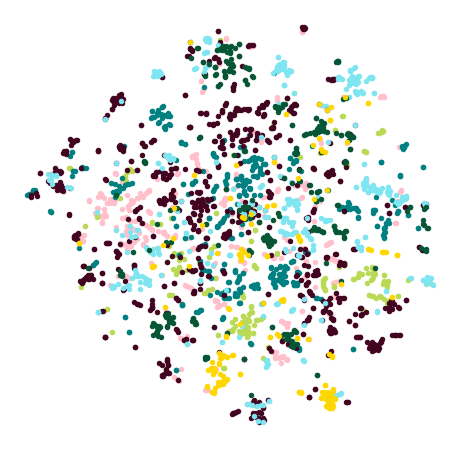

In [15]:

#%%
colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535', '#ffd700'
]
plot_points(colors)

In [18]:
model

ARGVA(
  (encoder): VEncoder(
    (conv1): GCNConv(1433, 64)
    (conv_mu): GCNConv(64, 32)
    (conv_logstd): GCNConv(64, 32)
  )
  (decoder): InnerProductDecoder()
  (discriminator): Discriminator(
    (lin1): Linear(in_features=32, out_features=64, bias=True)
    (lin2): Linear(in_features=64, out_features=64, bias=True)
    (lin3): Linear(in_features=64, out_features=1, bias=True)
  )
  (VGAE): VGAE(
    (encoder): VEncoder(
      (conv1): GCNConv(1433, 64)
      (conv_mu): GCNConv(64, 32)
      (conv_logstd): GCNConv(64, 32)
    )
    (decoder): InnerProductDecoder()
  )
)